# U-Net on Graphene Images
This is a modification to a U-Net on the Oxford-IIIT Pet Dataset. Original code is located at https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/unet.ipynb

### Download the dataset

In [1]:
% pip install --upgrade pip
% pip install gdown
% pip install wandb
% pip install imgaug
% pip install scikit-learn
# %pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ------------------------------------- 948.0/948.0 kB 10.0 MB/s eta 0:00:00
     --------------------------------------- 23.9/23.9 MB 13.3 MB/s eta 0:00:00
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
     ---------------------------------------- 1.4/1.4 MB 12.5 MB/s eta 0:00:00
  Using cached scipy-1.9.1-cp39-cp39-win_amd64.whl (38.6 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
     ---------------------------------------- 219.4/219.4 kB ? eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
Note: you may need to restart the kernel to use updated packages.
Note: yo

In [1]:
RESOURCES_DIR = '../resources/'

In [2]:
% env WANDB_NOTEBOOK_NAME=UNET_and_color.ipynb
import wandb

wandb.login()

env: WANDB_NOTEBOOK_NAME=UNET_and_color.ipynb


wandb: Currently logged in as: iluxa-kholkin (graphene). Use `wandb login --relogin` to force relogin


True

# Define hyper-parameters

In [2]:
import os
import sys

label_to_ind = {"ML": 0, "BL": 1, "3L": 2}
class_names = ['Background', 'Monolayer', 'Bilayer', 'Three layers']

LOAD_SCRAPED = False
DEFAULT_MEDIAN_INTENSITY = 0.6
APPLY_CORRECTION = True

EPOCHS = 200  # no. of training epochs
BATCH_SIZE = 20
DEFAULT_LEARNING_RATE = 5e-5

# define U-Net input image size
DEFAULT_INPUT_SIZE = (256, 256, 3)

# define weight of positive errors
POS_WEIGHT = 50

# start training your model. Set to 0 if you want to train from scratch
INITIAL_EPOCH = EPOCHS
THRESHOLD = 0.884

PROJECT_DIR = os.path.join(RESOURCES_DIR, 'models', 'UNet')

LOG_DIR = os.path.join(PROJECT_DIR, 'logs')
CHECKPOINT_DIR = os.path.join(PROJECT_DIR, 'checkpoints')

DATASET_DIR = os.path.join(RESOURCES_DIR, 'dataset')

# model paths to save or load the models
MODEL_PATH = os.path.join(CHECKPOINT_DIR, f'Unet_pw{POS_WEIGHT}.h5')

COLOR_MODEL_PATH = os.path.join(CHECKPOINT_DIR, f'Color_pw{POS_WEIGHT}.h5')

Import the libraries for use

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
import cv2
from imgaug import augmenters as iaa
from PIL import Image
import json
from tqdm import tqdm

tf.get_logger().setLevel('ERROR')

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print('failed to set memory growth')
    pass

[]
failed to set memory growth


# Dataset loading class

In [6]:
#@title Functions for printing the images conveniently

def print_images(images, labels, params=[]):
    n = len(images)
    fig, ax = plt.subplots(1, n, figsize=(10, 20 * n))
    if len(params) < n:
        params += [{} for i in range(n - len(params))]
    if n > 1:
        for i in range(n):
            ax[i].axis('off')
            ax[i].imshow(images[i], **params[i])
            ax[i].set_title(labels[i], fontsize=14)
    else:
        plt.axis()
        ax.imshow(images[0], **params[0])
        ax.set_title(labels[0], fonsize=14)
    plt.show()


def print_img_msk(image, masks):
    img = cv2.resize(image, (256, 256))
    step = 255 // 3
    msk_ML = cv2.resize(masks[:, :, label_to_ind['ML']] * step, DEFAULT_INPUT_SIZE[:2])
    msk_DL = cv2.resize(masks[:, :, label_to_ind['BL']] * 2 * step, DEFAULT_INPUT_SIZE[:2])
    msk_TL = cv2.resize(masks[:, :, label_to_ind['3L']] * 3 * step, DEFAULT_INPUT_SIZE[:2])
    print_images([img, msk_DL + msk_ML + msk_TL],
                 ['Image', 'Ground Truth'],
                 [{}, {'cmap': 'gray'}])
    # cv2_imshow(cv2.resize(image, (256, 256)))
    # cv2_imshow(cv2.resize(masks[:,:,0] * 255, (256, 256)) + cv2.resize(masks[:,:,1] * 128, (256, 256)))


In [7]:
#@title The Class holding the dataset
# This is very specific to the dataset.
# So, you need to change it if you have a different one.

mask_threshold = 254


def get_pic_filenames(dataset_type: str, pic_type: str):
    # dataset_type is either 'train' or 'val'
    # pic_type is either 'pure' or 'scraped'
    path = os.path.join(DATASET_DIR, dataset_type, pic_type, 'raw')
    possible_extensions = ('.jpg', '.png')
    pictures = np.array(
        list(filter(lambda file: file.endswith(possible_extensions), os.listdir(path))))
    return pictures


class Dataset:
    def __init__(self, dataset_type: str, load_scraped: bool):
        self.images = []
        self.corrected_images = None
        self.masks = []

        self.load_pure_images(dataset_type)
        if load_scraped:
            self.load_scraped_images(dataset_type)

        self.num_images = len(self.images)
        self.image_ids = np.arange(self.num_images)

        # print(self.masks.shape)
        # for i in self.image_ids:
        # print_img_msk(self.images[i], self.masks[i])

    def load_pure_images(self, dataset_type):
        pic_filenames = get_pic_filenames(dataset_type, "pure")
        path_pure_raw = os.path.join(DATASET_DIR, dataset_type, "pure", "raw")
        path_pure_mask = os.path.join(DATASET_DIR, dataset_type, "pure", "mask")

        self.images += [np.array(Image.open(os.path.join(path_pure_raw, pic))) for pic in pic_filenames]
        # print(pic_filenames)
        for pic in pic_filenames:
            with open(os.path.join(path_pure_mask, pic[:-4] + ".json"), 'r') as file:
                d = json.load(file)
                mask = np.zeros((d['imageHeight'], d['imageWidth'], len(label_to_ind)), np.uint8)
                for shape in d['shapes']:
                    if shape['label'] not in label_to_ind.keys():
                        raise RuntimeError('Unexpected label')
                    polygon = np.array(shape['points'], np.int32)
                    curmask = np.copy(mask[:, :, label_to_ind[shape['label']]])
                    cv2.fillPoly(curmask, [polygon], 1)
                    mask[:, :, label_to_ind[shape['label']]] = curmask
                self.masks.append(mask)

    def load_scraped_images(self, dataset_type):
        path_raw = os.path.join(DATASET_DIR, dataset_type, "scraped", "raw")
        path_ML = os.path.join(DATASET_DIR, dataset_type, "scraped", "mask", "ML")
        path_BL = os.path.join(DATASET_DIR, dataset_type, "scraped", "mask", "BL")
        scraped_filenames = get_pic_filenames(dataset_type, "scraped")

        self.images += [np.array(Image.open(os.path.join(path_raw, filename))) for filename in scraped_filenames]
        # print(self.images[-1].shape)

        for filename in scraped_filenames:
            mask = np.zeros((182, 182, len(label_to_ind)), np.uint8)
            mask[:, :, label_to_ind['ML']] = np.array(Image.open(os.path.join(path_ML, filename)))[:, :,
                                             0] >= mask_threshold
            mask[:, :, label_to_ind['BL']] = np.array(Image.open(os.path.join(path_BL, filename)))[:, :,
                                             0] >= mask_threshold
            self.masks.append(mask)

    def load_image(self, index, corrected=APPLY_CORRECTION, intensity=DEFAULT_MEDIAN_INTENSITY):
        if corrected:
            if self.corrected_images is None:
                return self._correct_median(self.images[index], intensity)
            return self.corrected_images[index]
        return self.images[index]

    def prepare(self, intensity=DEFAULT_MEDIAN_INTENSITY):
        self.corrected_images = []
        for i in range(self.num_images):
            self.corrected_images.append(self._correct_median(self.images[i], intensity))

    def _correct_median(self, image, intensity):
        r, g, b = cv2.split(image / 255.)
        rmedian, gmedian, bmedian = np.median(r), np.median(g), np.median(b)
        result = image / 255.
        result[:, :, 0] *= intensity / rmedian
        result[:, :, 1] *= intensity / gmedian
        result[:, :, 2] *= intensity / bmedian
        return (result * 255).clip(0, 255).astype(np.uint8)

    def load_mask(self, index):
        # where n_classes is 2 in case of mono\bilayer graphene
        # CLASS ID_S:
        #   1 - bilayer graphene
        #   2 - monolayer graphene
        return self.masks[index], np.array([label_to_ind['ML'],
                                            label_to_ind['BL'],
                                            label_to_ind['3L']])


def get_train_val_datasets(load_scraped=LOAD_SCRAPED):
    return Dataset("train", load_scraped), Dataset("val", load_scraped)

In [8]:
dataset_train, dataset_val = get_train_val_datasets(LOAD_SCRAPED)
if APPLY_CORRECTION:
    dataset_train.prepare()
    dataset_val.prepare()

In [9]:
print(f'{dataset_train.num_images} -- train size\n{dataset_val.num_images} -- val size')

98 -- train size
11 -- val size


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


np.mean(r)=0.658470893777565
np.mean(g)=0.6685766047611456
np.mean(b)=0.658435623571922
total_mean=0.661827707370211
rmedian=0.6509803921568628
gmedian=0.6509803921568628
bmedian=0.6431372549019608
========AFTER CORRECTION==========
np.mean(r)=0.6069038960720933
np.mean(g)=0.6162181959545499
np.mean(b)=0.6142722585762443
total_mean=0.661827707370211
rmedian=0.6
gmedian=0.6
bmedian=0.6
0.661827707370211


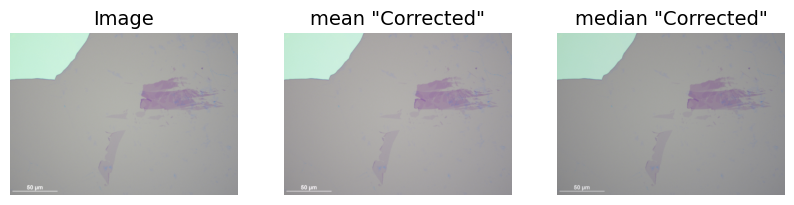

In [10]:
#@title Image "Correction" (not used, because isn't usefull) { run: "auto"}
index = 6  #@param {type:"slider", min:0, max:148, step:1}
# for index in range(11):
img = dataset_val.load_image(index, corrected=False) / 255.

r, g, b = cv2.split(img)
rmean, gmean, bmean = np.mean(r), np.mean(g), np.mean(b)
rmedian, gmedian, bmedian = np.median(r), np.median(g), np.median(b)

total_mean = np.sum(r + g + b) / (3 * r.size)
# total = rmean + gmean + bmean
# kr, kg, kb = total / (3 * rmean), total / (3 * gmean), total / (3 * bmean)

print(f'{np.mean(r)=}\n{np.mean(g)=}\n{np.mean(b)=}\n{total_mean=}')
print(f'{rmedian=}\n{gmedian=}\n{bmedian=}')

corrected_img = np.copy(img)
corrected_img[:, :, 0] *= total_mean / rmean
corrected_img[:, :, 1] *= total_mean / gmean
corrected_img[:, :, 2] *= total_mean / bmean

intensity = 0.6
corrected_img2 = np.copy(img)
corrected_img2[:, :, 0] *= intensity / rmedian
corrected_img2[:, :, 1] *= intensity / gmedian
corrected_img2[:, :, 2] *= intensity / bmedian

r, g, b = cv2.split(corrected_img2)
rmean, gmean, bmean = np.mean(r), np.mean(g), np.mean(b)
rmedian, gmedian, bmedian = np.median(r), np.median(g), np.median(b)

print(f'========AFTER CORRECTION==========\n{np.mean(r)=}\n{np.mean(g)=}\n{np.mean(b)=}\n{total_mean=}')
print(f'{rmedian=}\n{gmedian=}\n{bmedian=}')

print(total_mean)
print_images([img, corrected_img, corrected_img2],
             ['Image', 'mean "Corrected"', 'median "Corrected"'])

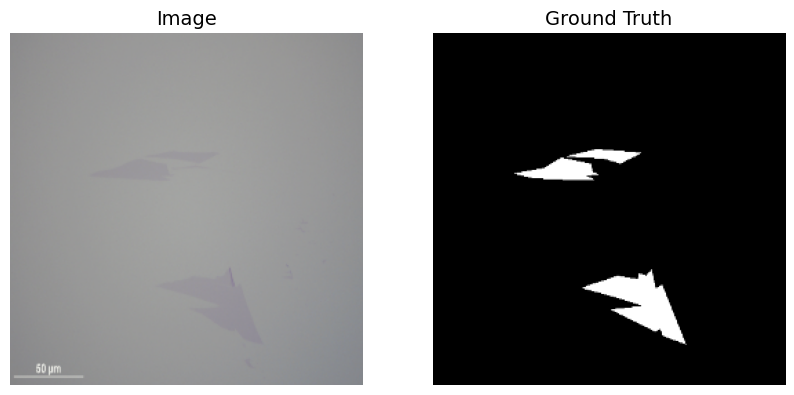

In [11]:
#@title `dataset_train.load_image{mask}(index)` { run: "auto"}
index = 10  #@param {type:"slider", min:0, max:147, step:1}

print_img_msk(dataset_train.load_image(index), dataset_train.load_mask(index)[0])

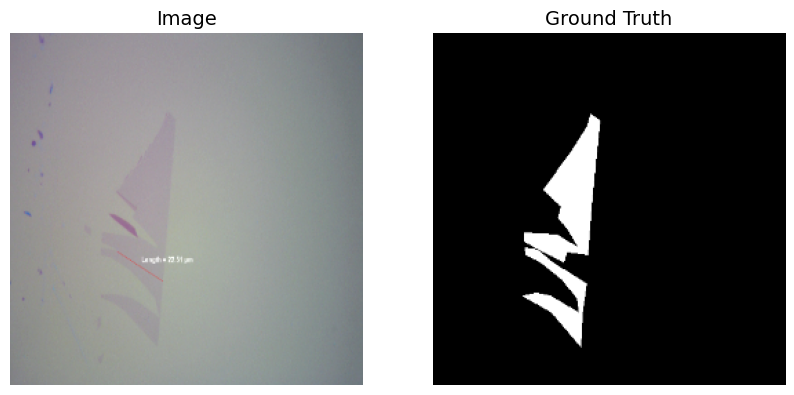

In [12]:
#@title `dataset_val.load_image{mask}(index)` { run: "auto"}
index = 4  #@param {type:"slider", min:0, max:17, step:1}

print_img_msk(dataset_val.load_image(index), dataset_val.load_mask(index)[0])

# Generator function

Define augmenter: 

In [13]:
# define augmenter
# first crop images at a random position
# then randomly apply 0 to 4 of the methods: horizontally flip, vertically flip, rotate and shift
seq_train = iaa.Sequential([
    iaa.SomeOf((0, 4), [
        iaa.Fliplr(),  # horizontally flip
        iaa.Flipud(),  # vertically flip
        iaa.Affine(rotate=(0, 359)),  # rotate
        iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),  # shift
        # More as you want ...
    ])
])


In [14]:
#@title Generator function

def image_generator(dataset, seq=None, batch_size=5, image_size=(256, 256)):
    while True:

        #extract a random batch
        batch = np.random.choice(dataset.image_ids, size=batch_size)

        #variables for collecting batches of inputs and outputs
        batch_x = []
        batch_y = []

        if seq:  # apply augmentation
            # make stochastic augmenter deterministic (similar to drawing random samples from a distribution)
            seq_det = seq.to_deterministic()

        for f in batch:
            #preprocess the raw images
            raw = dataset.load_image(f)

            raw = np.clip(cv2.resize(raw, dsize=image_size, interpolation=cv2.INTER_CUBIC), 0, 255)

            #get the mask
            mask = np.clip(np.sum(dataset.load_mask(f)[0], axis=-1, keepdims=True), a_min=0, a_max=1)
            mask = cv2.resize(mask.astype(np.float32), dsize=image_size, interpolation=cv2.INTER_CUBIC)

            # pre-process the mask
            mask[mask != 0] = 1
            batch_x.append(raw)
            batch_y.append(mask)

        # pre-process a batch of images and masks
        batch_x = np.array(batch_x) / 255.  # normalize raw images
        batch_y = np.expand_dims(np.array(batch_y), 3)  # add color channel to the black-and-white masks

        if seq:
            # augment images and masks
            batch_x = np.array(seq_det.augment_images(batch_x))
            batch_y = np.array(seq_det.augment_images(batch_y))

        yield (batch_x, batch_y)

In [15]:
# build generators for training and testing
train_generator = image_generator(dataset_train, seq=seq_train, batch_size=BATCH_SIZE,
                                  image_size=DEFAULT_INPUT_SIZE[:2])

test_generator = image_generator(dataset_val, seq=None, batch_size=BATCH_SIZE, image_size=DEFAULT_INPUT_SIZE[:2])

Test the generators by plotting the images

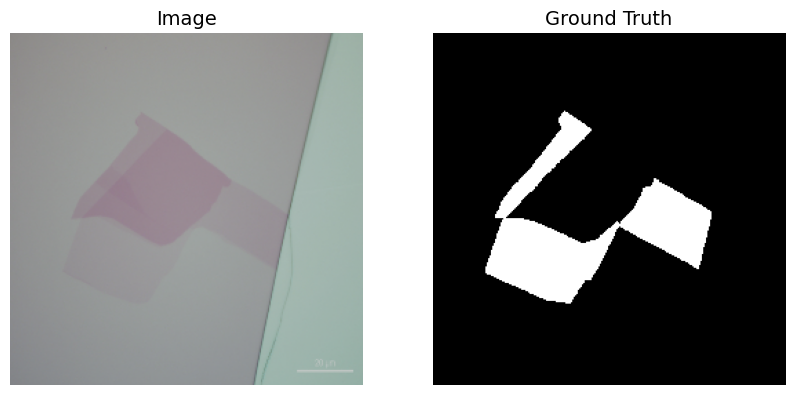

In [16]:
x, y = next(test_generator)  # x is the raw images, y is the ground truth masks

img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,) * 3, axis=-1)

print_images([img, msk], ['Image', 'Ground Truth'])

In [17]:
#@title Functions for loading

mask_type_to_int = {
    "ML": 0,
    "BL": 1,
    "3L": 2,
}


# layer_type: ML or BL
def load_mask(dataset, mask_ind, layer_type: str, mask_size=DEFAULT_INPUT_SIZE[:2]):
    # Returns: a mask of size (mask_size[0], mask_size[1]) of type float32
    # Values inside: 0. and 1.
    mask = np.clip(np.sum(dataset.load_mask(mask_ind)[0]
                          [:, :, [a for a in range(len(dataset_train.load_mask(i)[1])) if
                                  dataset_train.load_mask(i)[1][a] == mask_type_to_int[layer_type]]],
                          axis=-1, keepdims=True),
                   a_min=0, a_max=1)
    mask = cv2.resize(mask.astype(np.float32), dsize=mask_size, interpolation=cv2.INTER_CUBIC)
    mask[mask != 0] = 1
    return mask


def load_raw(dataset, img_ind, img_size=DEFAULT_INPUT_SIZE[:2]):
    # Returns: a raw image resized to size (img_size[0], img_size[1], 3) of float32
    # Values: normalized to [0, 1)
    return cv2.resize(dataset.load_image(img_ind),  # Original raw images
                      dsize=img_size,
                      interpolation=cv2.INTER_CUBIC) / 255

# Metrics

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [18]:
# miou_metric = tf.keras.metrics.MeanIoU(num_classes=2)
def mean_iou(y_true, y_pred):
    # miou_metric.reset_state()
    # miou_metric.update_state(y_true, y_pred > THRESHOLD)
    yt0 = y_true[:, :, :, 0]
    yp0 = K.cast(y_pred[:, :, :, 0] > THRESHOLD, 'float32')
    inter = tf.math.count_nonzero(tf.math.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter / union, 'float32'))
    return iou


def precision(y_true, y_pred_mask):
    y_pred_mask = K.cast(y_pred_mask > THRESHOLD, 'float32')
    tp = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_mask, 1)))
    fp = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 0), tf.equal(y_pred_mask, 1)))
    return tp / (tp + fp) if tp + fp != 0 else tf.constant(0, 'float64')


def recall(y_true, y_pred_mask):
    y_pred_mask = K.cast(y_pred_mask > THRESHOLD, 'float32')
    tp = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_mask, 1)))
    fn = tf.math.count_nonzero(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_mask, 0)))
    return tp / (tp + fn) if tp + fn != 0 else tf.constant(0, 'float64')


t = np.array([[1, 1], [0, 0]]).astype(np.float32)
p = np.array([[1, 1], [1, 0]])
print(mean_iou(t[None, :, :, None], p[None, :, :, None]), precision(t, p), recall(t, p))

tf.Tensor(0.6666667, shape=(), dtype=float32) tf.Tensor(0.6666666666666666, shape=(), dtype=float64) tf.Tensor(1.0, shape=(), dtype=float64)


# UNet model

Model for identifying interesting regions.

## Weighted binary crossentropy loss 
Assume we have $N$ samples in total, $y_{true}$ is a ground truth segmentation mask, $y_{pred}$ is the CNN-predicted segmentation mask, the binary crossentropy is defined as:
$$L_{binary\_ce} = -\frac{1}{N}\sum_{1}^{N}y_{true} * log(y_{pred})+(1-y_{true})*log(1-y_{pred})$$
And weighted binary crossentropy is defined as:
$$L_{w\_binary\_ce} = -\frac{1}{N}\sum_{1}^{N} w * y_{true} * log(y_{pred})+(1-y_{true})*log(1-y_{pred})$$
Here, $w$ represents the weight for positive errors. Weighted loss here is used to handle class imbalance in the dataset.

In [19]:
def create_weighted_binary_crossentropy(pos_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * pos_weight + (1. - y_true)
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

## UNet model function

In [20]:
def unet_attached(sz=DEFAULT_INPUT_SIZE):
    x = Input(sz)
    inputs = x

    #down sampling
    Num_of_filters = 8
    layers = []

    for i in range(6):
        x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)
        layers.append(x)
        x = MaxPooling2D()(x)
        Num_of_filters = Num_of_filters * 2

    ff2 = 64

    #bottleneck
    j = len(layers) - 1
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j - 1

    #upsampling
    for i in range(5):
        ff2 = ff2 // 2
        Num_of_filters = Num_of_filters // 2
        x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j - 1

        #classification
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(Num_of_filters, 3, activation='relu', padding='same')(x)

    ########################################################
    ###### Attached layers to the original UNet model ######
    ########################################################
    x = Conv2D(256, 5, activation='linear', padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = Conv2D(128, 5, activation='linear', padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = Conv2D(64, 5, activation='linear', padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = Conv2D(32, 5, activation='linear', padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = Conv2D(16, 5, activation='linear', padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    ########################################################
    ########################################################

    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    #model creation
    model = Model(inputs=[inputs], outputs=[outputs])

    # Optimizer for the model
    opt = keras.optimizers.Adam(learning_rate=DEFAULT_LEARNING_RATE)  # use Adam as optimizer

    # Compile the model
    model.compile(optimizer=opt, loss=create_weighted_binary_crossentropy(POS_WEIGHT),
                  metrics=[mean_iou, precision, recall])

    return model


## Custom callbacks

In [21]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath=MODEL_PATH, verbose=0, save_best_only=True, save_weights_only=False)
    callbacks = [checkpointer, PlotLearning()]
    return callbacks


# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))

        if enable_wandb:
            wandb.log({'train/loss': logs.get('loss'),
                       'train/mean_iou': logs.get('mean_iou'),
                       'train/recall': logs.get('recall'),
                       'val/loss': logs.get('val_loss'),
                       'val/mean_iou': logs.get('val_mean_iou'),
                       'val/recall': logs.get('val_recall'),
                       })

        print('epoch =', epoch,
              'loss=', logs.get('loss'),
              'val_loss=', logs.get('val_loss'),
              'mean_iou=', logs.get('mean_iou'),
              'val_mean_iou=', logs.get('val_mean_iou'),
              'recall=', logs.get('recall'),
              'val_recall=', logs.get('val_recall'))
        if epoch % 5 != 0 and epoch != EPOCHS - 1:
            return

        if enable_wandb:
            table = wandb.Table(
                columns=['raw', 'prediction', 'pred_with_threshold', 'true_mask', 'iou', 'recall', 'precision'])
        fig, ax = plt.subplots(3, 4, figsize=(10, 8))
        [axi.set_axis_off() for axi in ax.ravel()]
        for i in range(3):
            #choose a test image and preprocess
            # path = np.random.choice(dataset_val.image_ids)
            test_index_to_print = i
            raw = cv2.resize(dataset_val.load_image(test_index_to_print),
                             dsize=DEFAULT_INPUT_SIZE[:2],
                             interpolation=cv2.INTER_CUBIC) / 255.
            # get ground truth mask
            mask = np.clip(np.sum(dataset_val.load_mask(test_index_to_print)[0], axis=-1, keepdims=True), a_min=0,
                           a_max=1)
            mask = cv2.resize(mask.astype(np.float32), dsize=DEFAULT_INPUT_SIZE[:2], interpolation=cv2.INTER_CUBIC)

            # pre-process the mask
            mask[mask != 0] = 1
            # mask = np.tile(mask[:,:,np.newaxis], (1,1,3))

            #predict the mask
            pred = model_attached.predict(np.expand_dims(raw, 0), verbose=0)

            # predicted mask post-processing
            pred = np.clip(pred.squeeze(), 0, 1)

            pred_mask = np.array(pred) > THRESHOLD
            # pred_mask = exponen(pred_mask)

            if enable_wandb:
                table.add_data(wandb.Image(raw * 255), wandb.Image(pred * 255), wandb.Image(pred_mask * 255),
                               wandb.Image(mask * 255),
                               mean_iou(mask[None, :, :, None], pred_mask[None, :, :, None]), recall(mask, pred_mask),
                               precision(mask, pred_mask))

            #show the mask and the segmented image
            ax[i][0].imshow(raw)
            ax[i][0].set_title('Image', fontsize=14)
            ax[i][1].imshow(mask, cmap='gray', vmin=0., vmax=1.)
            ax[i][1].set_title('Ground Truth', fontsize=14)
            ax[i][2].imshow(pred, cmap='gray', vmin=0., vmax=1.)
            ax[i][2].set_title('Prediction', fontsize=14)
            ax[i][3].imshow(pred_mask, cmap='gray', vmin=0., vmax=1.)
            ax[i][3].set_title('Post-processed prediction', fontsize=14)

        if enable_wandb:
            wandb.log({'interesting_region_table': table}, commit=False)
        plt.show()

## Build the model and train

In [22]:
MODEL_PATH

'../resources/models\\UNet\\checkpoints\\Unet_pw50.h5'

In [23]:
enable_wandb = True
force_new_model = False

TRAIN_STEPS = (dataset_train.num_images + BATCH_SIZE - 1) // BATCH_SIZE
TEST_STEPS = (dataset_val.num_images + BATCH_SIZE - 1) // BATCH_SIZE

get_custom_objects().update({"weighted_binary_crossentropy": create_weighted_binary_crossentropy(POS_WEIGHT),
                             "mean_iou": mean_iou,
                             "recall": recall,
                             "precision": precision})

# code checking if ckpt exists
if os.path.isfile(MODEL_PATH) and not force_new_model:
    model_attached = load_model(MODEL_PATH)
    INITIAL_EPOCH = EPOCHS
else:
    INITIAL_EPOCH = 0
    model_attached = unet_attached()

if EPOCHS != INITIAL_EPOCH:
    # print model summary
    # model_attached.summary()
    if enable_wandb:
        wandb.init(project='UNET_test',
                   dir=LOG_DIR,
                   config={
                       'epochs': EPOCHS - INITIAL_EPOCH,
                       'batch_size': BATCH_SIZE,
                       'learning_rate': DEFAULT_LEARNING_RATE,
                       'positive_weight': POS_WEIGHT,
                       'load_scraped': LOAD_SCRAPED,
                       'apply_correction': APPLY_CORRECTION,
                   })

    model_attached.fit(train_generator,
                       epochs=EPOCHS,
                       initial_epoch=INITIAL_EPOCH,
                       steps_per_epoch=TRAIN_STEPS,
                       validation_data=test_generator,
                       validation_steps=TEST_STEPS,
                       callbacks=build_callbacks(),
                       verbose=0)

    if enable_wandb:
        wandb.finish()

### Plot raw images + ground truth masks + detection masks for attached UNet model

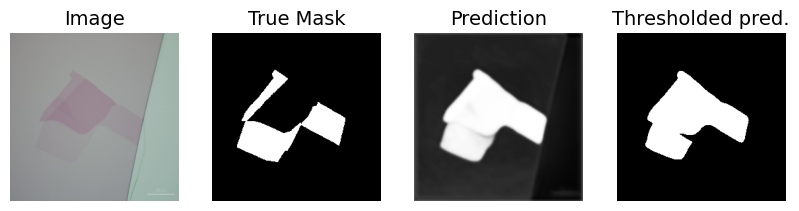

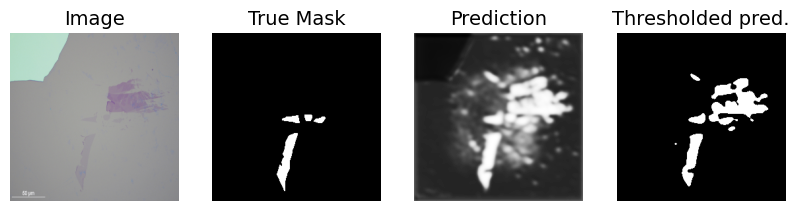

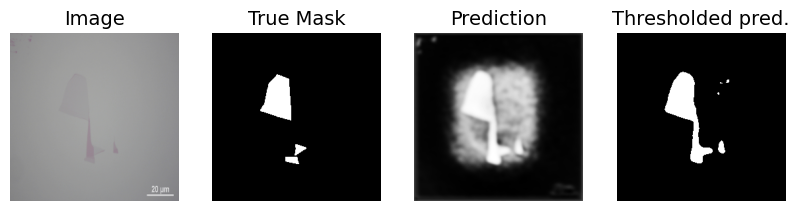

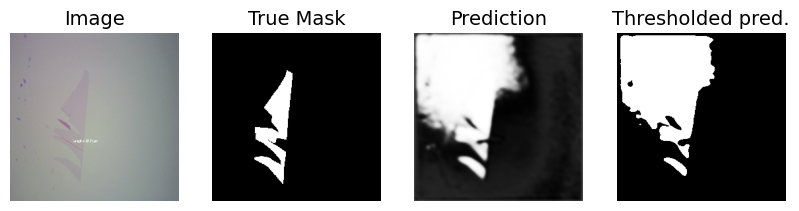

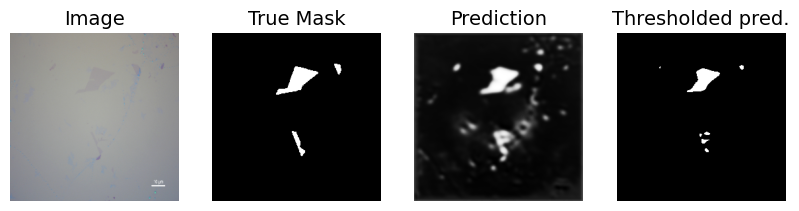

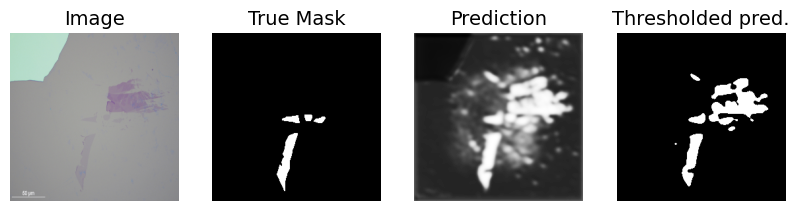

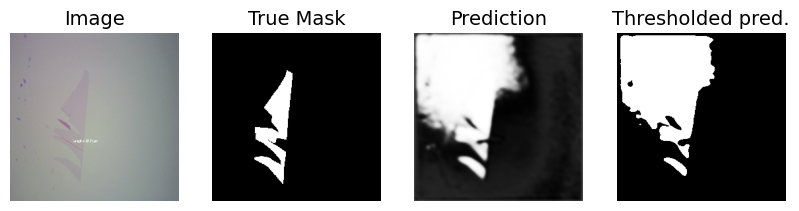

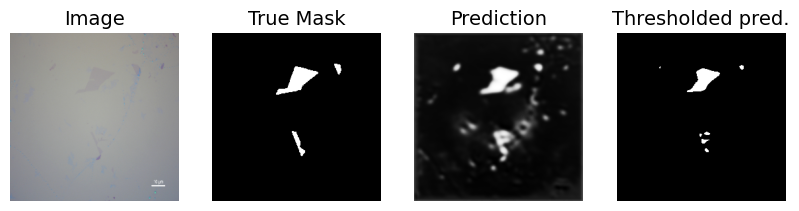

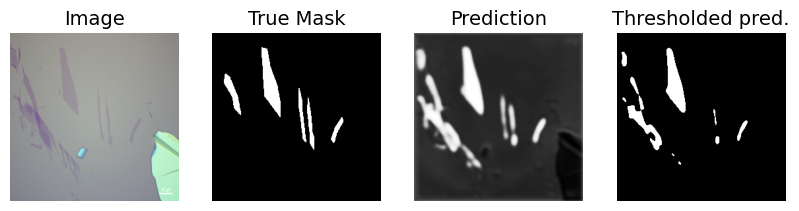

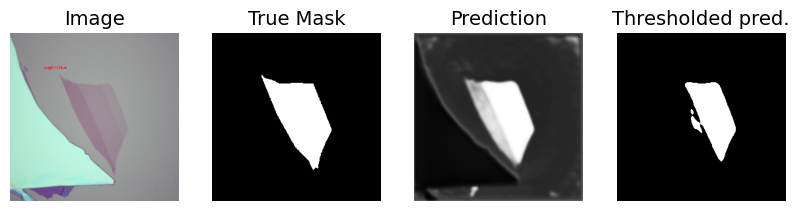

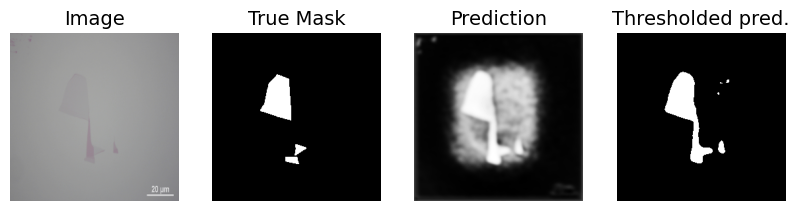

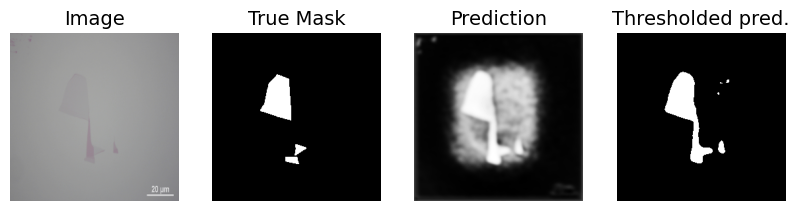

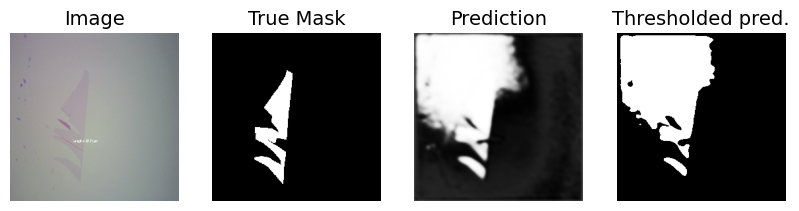

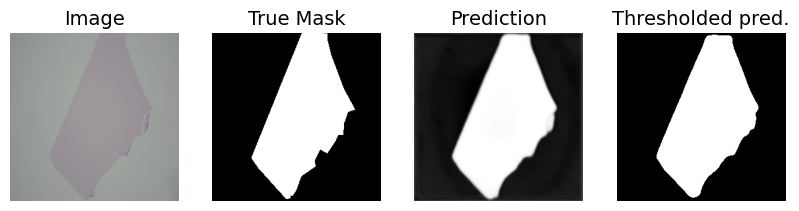

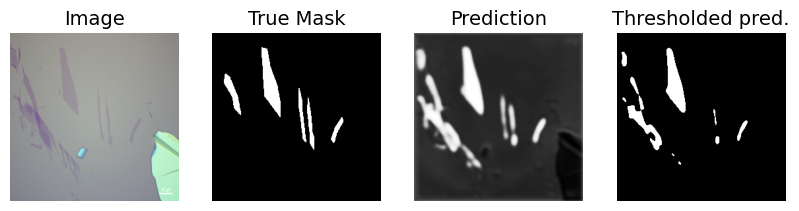

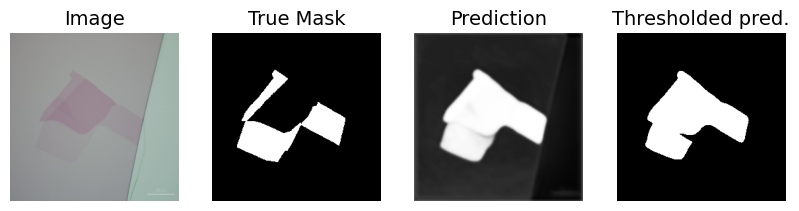

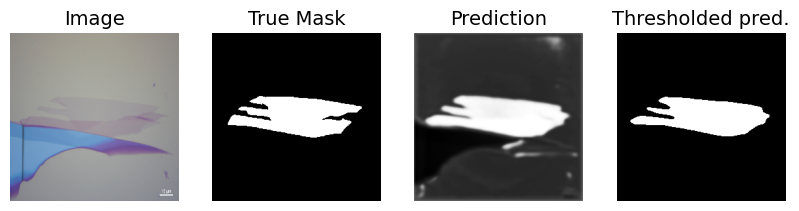

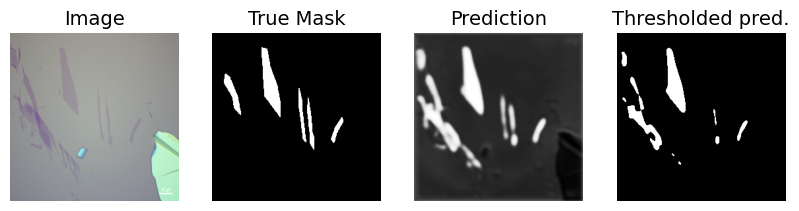

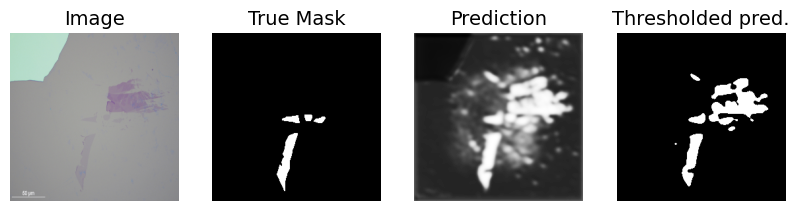

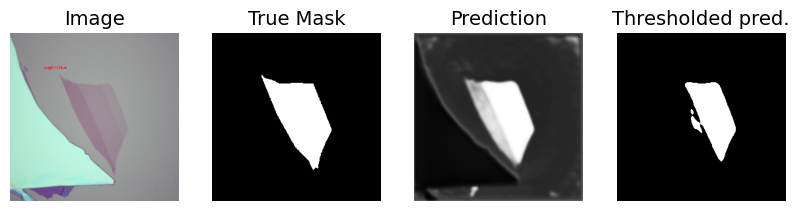

0.07313232421875
0.07890265906307208


In [24]:
for i in range(BATCH_SIZE):
    img = x[i]
    msk = y[i].squeeze()
    pred = model_attached.predict(np.expand_dims(img, 0), verbose=0).squeeze()
    pred_mask = (pred >= THRESHOLD).astype(np.float32)  # pred >= THRESHOLD
    print_images([img, msk, pred, pred_mask], ['Image', 'True Mask', 'Prediction', 'Thresholded pred.'],
                 [{}] + [{'cmap': 'gray'}] * 3)

total_msk_graphene = np.sum(y)
grd_graphene_to_whole_image = total_msk_graphene / (DEFAULT_INPUT_SIZE[0] * DEFAULT_INPUT_SIZE[1] * BATCH_SIZE)
grd_graphene_to_bg = total_msk_graphene / (
            DEFAULT_INPUT_SIZE[0] * DEFAULT_INPUT_SIZE[1] * BATCH_SIZE - total_msk_graphene)
print(grd_graphene_to_whole_image)
print(grd_graphene_to_bg)

# Evaluation Metrics

In [25]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def false_alarm_m(y_true, y_pred):
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_alarm = false_positives / (false_positives + true_negatives)
    return false_alarm


recall_m(msk, pred_mask)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6566768>

In [26]:
def compute_recall_precision(dataset,
                             threshold,
                             model_name,
                             model_name2=None,
                             sz=DEFAULT_INPUT_SIZE[:2]):
    recall = 0
    precision = 0
    false_alarm = 0

    for im_id in tqdm(dataset.image_ids):

        #get the mask
        mask = np.clip(np.sum(dataset.load_mask(im_id)[0], axis=-1, keepdims=True), a_min=0, a_max=1)
        mask = cv2.resize(mask.astype(np.float32), dsize=sz, interpolation=cv2.INTER_CUBIC)

        #preprocess the raw images 
        raw = cv2.resize(dataset.load_image(im_id), dsize=sz, interpolation=cv2.INTER_CUBIC)
        pred = model_name.predict(np.expand_dims(raw / 255., 0),
                                  verbose=0).squeeze()  # raw image (256,256,3), after expansion: (1, 256, 256, 3)

        if model_name2 != None:
            pred = pred[:, :, None] * (raw / 255.)
            pred = model_name2.predict(np.expand_dims(pred,
                                                      0)).squeeze()  #pred(=raw image * pred mask ) (256,256,3), after expansion: (1, 256, 256, 3)

        # Threshold it to 0 or 1
        pred_mask = (pred >= threshold).astype(np.float32)
        recall += recall_m(mask, pred_mask)
        precision += precision_m(mask, pred_mask)
        false_alarm += false_alarm_m(mask, pred_mask)

    recall /= len(dataset.image_ids)
    precision /= len(dataset.image_ids)
    false_alarm /= len(dataset.image_ids)
    return (recall, precision, false_alarm)

In [27]:
rec_val_attached_value, prec_val_attached_values, false_ala_val_attached_value = compute_recall_precision(dataset_val,
                                                                                                          THRESHOLD,
                                                                                                          model_attached)
print(rec_val_attached_value, prec_val_attached_values, false_ala_val_attached_value)

100%|██████████| 11/11 [00:06<00:00,  1.66it/s]

tf.Tensor(0.87547785, shape=(), dtype=float32) tf.Tensor(0.6467882, shape=(), dtype=float32) tf.Tensor(0.051649652, shape=(), dtype=float32)


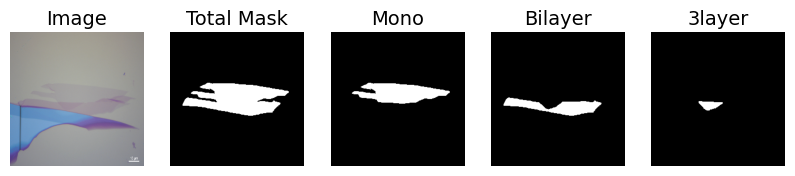

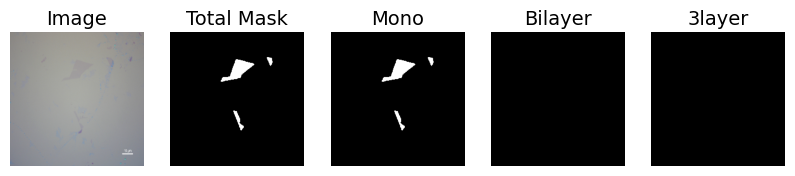

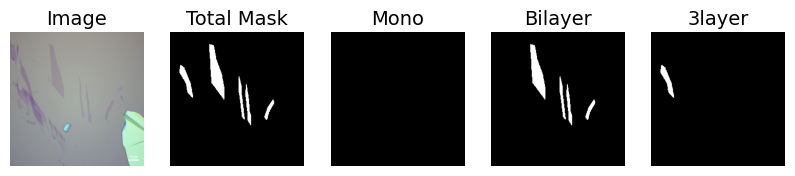

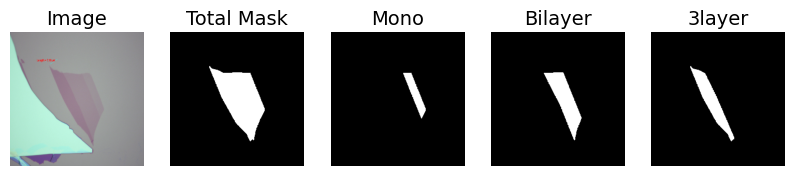

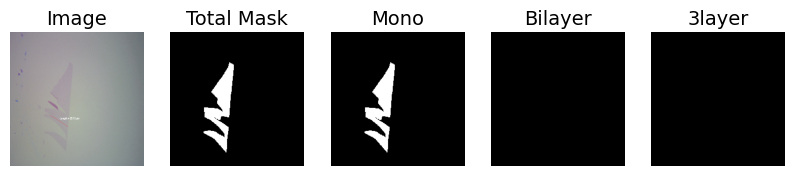

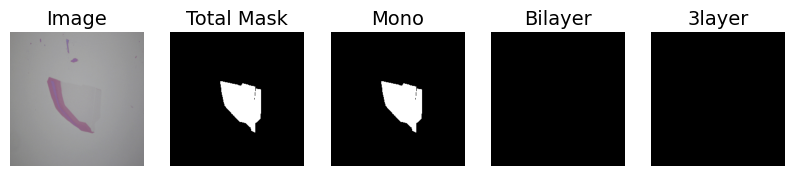

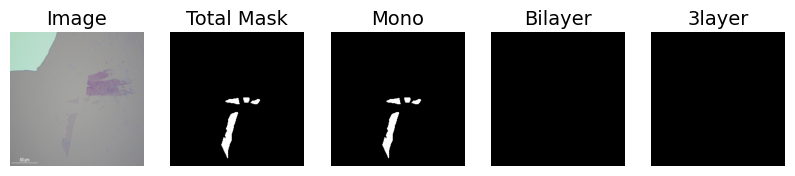

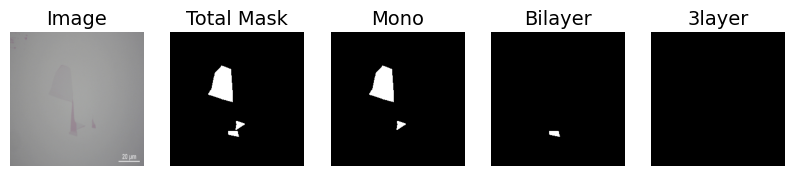

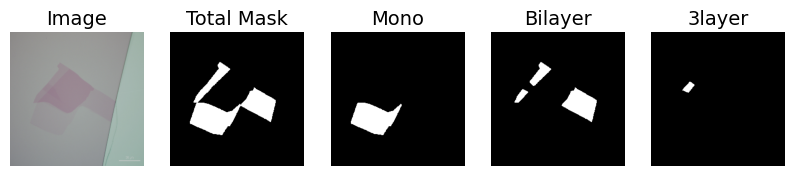

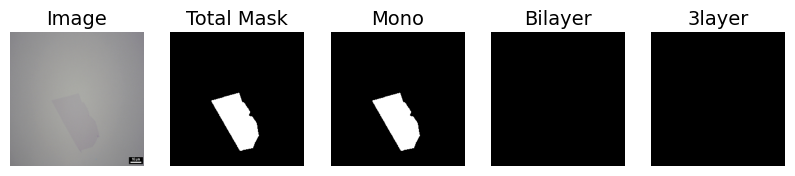

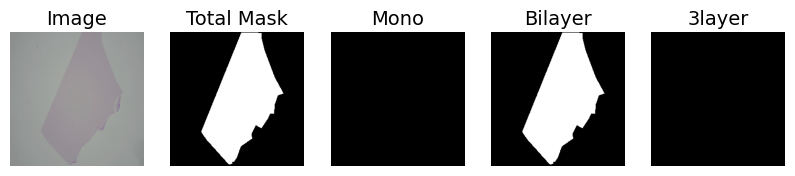

In [28]:
for j in range(dataset_val.num_images):
    raw = load_raw(dataset_val, j)
    # Ground truth monolayer
    mmask = load_mask(dataset_val, j, 'ML')
    # Ground truth bilayer
    bmask = load_mask(dataset_val, j, 'BL')
    # Ground truth 3layer
    tmask = load_mask(dataset_val, j, '3L')
    # Ground truth both layers
    mask = np.clip(mmask + bmask + tmask, 0, 1)

    print_images([raw, mask, mmask, bmask, tmask], ['Image', 'Total Mask', 'Mono', 'Bilayer', '3layer'],
                 [{}] + [{'cmap': 'gray'}] * 4)


# Color training dataset

In [29]:
## Step 1. Create empty lists to store pixel values
R0 = []  # create 3 lists to store background pixel values
G0 = []
B0 = []
R1 = []  # create 3 lists to store monolayer pixel values
G1 = []
B1 = []
R2 = []  # create 3 lists to store bilayer pixel values
G2 = []
B2 = []
R3 = []  # create 3 lists to store 3layer pixel values
G3 = []
B3 = []

## Step 2. Load total ground truth RGB pixel intensities multiplied by UNet masks
for i in tqdm(range(dataset_train.num_images), position=0, leave=True):

    raw = cv2.resize(dataset_train.load_image(i),  # Original raw images
                     dsize=DEFAULT_INPUT_SIZE[:2],
                     interpolation=cv2.INTER_CUBIC) / 255.
    pred_mask = model_attached.predict(np.expand_dims(raw, 0), verbose=0).squeeze()  # predict masks from UNet
    graphene_pred = pred_mask[:, :, None] * raw
    graphene_pred = graphene_pred * (1 + np.sign(pred_mask[:, :, None] - THRESHOLD)) / 2

    #Ground truth monolayer
    mmask = load_mask(dataset_train, i, "ML")
    graphene1 = mmask[:, :, None] * graphene_pred  # Unet predicted monolayer mask

    # Ground truth bilayer
    bmask = load_mask(dataset_train, i, "BL")
    graphene2 = bmask[:, :, None] * graphene_pred  # Unet predicted bilayer mask

    # Ground truth 3layer
    tmask = load_mask(dataset_train, i, "3L")
    graphene3 = tmask[:, :, None] * graphene_pred  # Unet predicted bilayer mask

    # Combine the monolayer and bilayer ground truths
    graphene = np.concatenate([graphene1, graphene2, graphene3], axis=0)
    r, g, b = cv2.split(graphene)
    # fig = plt.figure()
    # axis = fig.add_subplot(1, 1, 1, projection="3d")
    pixel_colors = graphene.reshape((np.shape(graphene)[0] * np.shape(graphene)[1], 3))

    ## Step 3. Plot the RGB distribution of total ground truth pixel intensities multiplied by UNet masks
    pix_c = []
    R = []
    G = []
    B = []
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()
    for j in range(len(r)):
        if r[j] + g[j] + b[j] != 0:
            R.append(r[j])
            G.append(g[j])
            B.append(b[j])
            pix_c.append(pixel_colors[j])
    R = np.array(R)
    G = np.array(G)
    B = np.array(B)
    # axis.scatter(R, G, B, facecolors =pix_c, marker=".")
    # axis.set_xlabel("Red")
    # axis.set_ylabel("Green")
    # axis.set_zlabel("Blue")
    # plt.show()

    ## Step 4. Prepare and store the background, monolayer and bilayer RGB pixel values separately
    # Monolayer
    r1, g1, b1 = cv2.split(graphene1)  # monolayer RGB pixel intensities
    r1 = r1.flatten()
    g1 = g1.flatten()
    b1 = b1.flatten()
    for j in range(len(r1)):
        if r1[j] + g1[j] + b1[j] != 0:
            R1.append(r1[j])
            G1.append(g1[j])
            B1.append(b1[j])

            # Bilayer
    r2, g2, b2 = cv2.split(graphene2)  # graphene1 is monolayer
    r2 = r2.flatten()
    g2 = g2.flatten()
    b2 = b2.flatten()
    for j in range(len(r2)):
        if r2[j] + g2[j] + b2[j] != 0:
            R2.append(r2[j])
            G2.append(g2[j])
            B2.append(b2[j])

    # 3layer
    r3, g3, b3 = cv2.split(graphene3)  # graphene1 is monolayer
    r3 = r3.flatten()
    g3 = g3.flatten()
    b3 = b3.flatten()
    for j in range(len(r3)):
        if r3[j] + g3[j] + b3[j] != 0:
            R3.append(r3[j])
            G3.append(g3[j])
            B3.append(b3[j])

    # for background
    mask = np.clip(np.sum(dataset_train.load_mask(i)[0], axis=-1, keepdims=True), a_min=0, a_max=1)
    mask = cv2.resize(mask.astype(np.float32), dsize=DEFAULT_INPUT_SIZE[:2], interpolation=cv2.INTER_CUBIC)
    # pre-process the mask 
    mask[mask != 0] = 1
    background = (1 - mask)[:, :, None] * graphene_pred
    r0, g0, b0 = cv2.split(background)  # graphene1 is monolayer
    r0 = r0.flatten()
    g0 = g0.flatten()
    b0 = b0.flatten()
    for j in range(len(r0)):
        if r0[j] + g0[j] + b0[j] != 0:
            R0.append(r0[j])
            G0.append(g0[j])
            B0.append(b0[j])

## Step 5. Convert the RGB list to array 
R1 = np.array(R1)
G1 = np.array(G1)
B1 = np.array(B1)
result1 = np.ones(len(R1))  # monolayer

R2 = np.array(R2)
G2 = np.array(G2)
B2 = np.array(B2)
result2 = 2 * np.ones(len(R2))  # bilayer

R3 = np.array(R3)
G3 = np.array(G3)
B3 = np.array(B3)
result3 = 3 * np.ones(len(R3))  # 3layer

R0 = np.array(R0)
G0 = np.array(G0)
B0 = np.array(B0)
result0 = np.zeros(len(R0))  # background

## Step 6. Combine the RGB values of monolayer, bilayer and background for SVM input dataset
graphene_R_train = np.concatenate([R0, R1, R2, R3], axis=0)
graphene_G_train = np.concatenate([G0, G1, G2, G3], axis=0)
graphene_B_train = np.concatenate([B0, B1, B2, B3], axis=0)
result_train = np.concatenate([result0, result1, result2, result3], axis=0)

100%|██████████| 98/98 [01:32<00:00,  1.06it/s]


# Color testing dataset

In [30]:
## Step 1. Create empty lists to store pixel values
R0 = []  # create 3 lists to store background pixel values
G0 = []
B0 = []
R1 = []  # create 3 lists to store monolayer pixel values
G1 = []
B1 = []
R2 = []  # create 3 lists to store bilayer pixel values
G2 = []
B2 = []
R3 = []  # create 3 lists to store 3layer pixel values
G3 = []
B3 = []

tp0 = 0
fn1 = 0
fn2 = 0
fn3 = 0

## Step 2. Load total ground truth RGB pixel intensities multiplied by UNet masks
for i in tqdm(range(dataset_val.num_images)):

    raw = cv2.resize(dataset_val.load_image(i),  # Original raw images
                     dsize=DEFAULT_INPUT_SIZE[:2],
                     interpolation=cv2.INTER_CUBIC) / 255.
    pred_mask = model_attached.predict(np.expand_dims(raw, 0), verbose=0).squeeze()  # predict masks from UNet
    graphene_pred = pred_mask[:, :, None] * raw
    graphene_pred = graphene_pred * (pred_mask[:, :, None] > THRESHOLD)

    raw_mask = dataset_val.load_mask(i)[0]
    total_mask = np.concatenate([1 - np.clip(np.sum(raw_mask, axis=2), 0, 1)[:, :, None], raw_mask], axis=2).astype(
        np.uint8)
    total_mask = cv2.resize(total_mask, dsize=DEFAULT_INPUT_SIZE[:2], interpolation=cv2.INTER_LINEAR)
    total_mask = np.argmax(total_mask, axis=2)

    #Ground truth monolayer
    mmask = (total_mask == 1).astype(np.float32)
    graphene1 = mmask[:, :, None] * graphene_pred  # Unet predicted monolayer mask
    fn1 += np.sum((mmask > 0.9) * (pred_mask < THRESHOLD))

    # Ground truth bilayer
    bmask = (total_mask == 2).astype(np.float32)
    graphene2 = bmask[:, :, None] * graphene_pred  # Unet predicted bilayer mask
    fn2 += np.sum((bmask > 0.9) * (pred_mask < THRESHOLD))

    # Ground truth 3layer
    tmask = (total_mask == 3).astype(np.float32)
    graphene3 = tmask[:, :, None] * graphene_pred  # Unet predicted bilayer mask
    fn3 += np.sum((tmask > 0.9) * (pred_mask < THRESHOLD))

    # Combine the monolayer and bilayer ground truths
    graphene = np.concatenate([graphene1, graphene2, graphene3], axis=0)
    r, g, b = cv2.split(graphene)
    # fig = plt.figure()
    # axis = fig.add_subplot(1, 1, 1, projection="3d")
    pixel_colors = graphene.reshape((np.shape(graphene)[0] * np.shape(graphene)[1], 3))

    ## Step 3. Plot the RGB distribution of total ground truth pixel intensities multiplied by UNet masks
    pix_c = []
    R = []
    G = []
    B = []
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()
    for j in range(len(r)):
        if r[j] + g[j] + b[j] != 0:
            R.append(r[j])
            G.append(g[j])
            B.append(b[j])
            pix_c.append(pixel_colors[j])
    R = np.array(R)
    G = np.array(G)
    B = np.array(B)
    # axis.scatter(R, G, B, facecolors =pix_c, marker=".")
    # axis.set_xlabel("Red")
    # axis.set_ylabel("Green")
    # axis.set_zlabel("Blue")
    # plt.show()

    ## Step 4. Prepare and store the background, monolayer and bilayer RGB pixel values separately
    # Monolayer
    r1, g1, b1 = cv2.split(graphene1)  # monolayer RGB pixel intensities
    r1 = r1.flatten()
    g1 = g1.flatten()
    b1 = b1.flatten()
    for j in range(len(r1)):
        if r1[j] + g1[j] + b1[j] != 0:
            R1.append(r1[j])
            G1.append(g1[j])
            B1.append(b1[j])

            # Bilayer
    r2, g2, b2 = cv2.split(graphene2)  # graphene1 is monolayer
    r2 = r2.flatten()
    g2 = g2.flatten()
    b2 = b2.flatten()
    for j in range(len(r2)):
        if r2[j] + g2[j] + b2[j] != 0:
            R2.append(r2[j])
            G2.append(g2[j])
            B2.append(b2[j])

    # 3layer
    r3, g3, b3 = cv2.split(graphene3)  # graphene1 is monolayer
    r3 = r3.flatten()
    g3 = g3.flatten()
    b3 = b3.flatten()
    for j in range(len(r3)):
        if r3[j] + g3[j] + b3[j] != 0:
            R3.append(r3[j])
            G3.append(g3[j])
            B3.append(b3[j])

    # for background
    mask = (total_mask != 0).astype(np.float32)
    background = (1 - mask)[:, :, None] * graphene_pred
    tp0 += np.sum((mask < 0.1) * (pred_mask < THRESHOLD))
    r0, g0, b0 = cv2.split(background)  # graphene1 is monolayer
    r0 = r0.flatten()
    g0 = g0.flatten()
    b0 = b0.flatten()
    for j in range(len(r0)):
        if r0[j] + g0[j] + b0[j] != 0:
            R0.append(r0[j])
            G0.append(g0[j])
            B0.append(b0[j])

## Step 5. Convert the RGB list to array 
R1 = np.array(R1)
G1 = np.array(G1)
B1 = np.array(B1)
result1 = np.ones(len(R1))  # monolayer

R2 = np.array(R2)
G2 = np.array(G2)
B2 = np.array(B2)
result2 = 2 * np.ones(len(R2))  # bilayer

R3 = np.array(R3)
G3 = np.array(G3)
B3 = np.array(B3)
result3 = 3 * np.ones(len(R3))  # 3layer

R0 = np.array(R0)
G0 = np.array(G0)
B0 = np.array(B0)
result0 = np.zeros(len(R0))  # background

## Step 6. Combine the RGB values of monolayer, bilayer and background for SVM input dataset
graphene_R_val = np.concatenate([R0, R1, R2, R3], axis=0)
graphene_G_val = np.concatenate([G0, G1, G2, G3], axis=0)
graphene_B_val = np.concatenate([B0, B1, B2, B3], axis=0)
result_val = np.concatenate([result0, result1, result2, result3], axis=0)

100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


In [31]:
out_of_interesting_region = np.array([0] * tp0 + [1] * fn1 + [2] * fn2 + [3] * fn3)

In [32]:
vals = [result0.shape[0] + tp0, result1.shape[0] + fn1, result2.shape[0] + fn2, result3.shape[0] + fn3]
print(*vals)
print(np.sum(vals))

658402 26584 32224 3686
720896


# Data Preparation

In [33]:
# Preparing for the training dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

X_Train = np.stack((graphene_R_train, graphene_G_train, graphene_B_train), axis=0)
X_Train = X_Train.transpose()

X_Test = np.stack((graphene_R_val, graphene_G_val, graphene_B_val), axis=0)
X_Test = X_Test.transpose()

Y_Train = result_train
Y_Test = result_val
y_full_test = np.concatenate([Y_Test, out_of_interesting_region])

In [34]:
# Dataset Normalization
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_Train = sc_X.fit_transform(X_Train)
X_Test = sc_X.transform(X_Test)

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_Train, Y_Train, train_size=0.8)

In [36]:
print(x_train.shape)
print(x_val.shape)
print(X_Test.shape)

(487176, 3)
(121794, 3)
(91254, 3)


In [37]:
n_classes = 4


def data_loader(X, y, batch_size=64):
    while True:
        batch = np.random.choice(X.shape[0], batch_size)
        batch_x = X[batch]
        batch_y = y[batch]
        batch_y = np.eye(n_classes)[batch_y.astype(np.int32)]
        yield batch_x, batch_y


y_train_one_hot = np.eye(n_classes)[y_train.astype(np.int32)]
y_val_one_hot = np.eye(n_classes)[y_val.astype(np.int32)]
Y_Test_one_hot = np.eye(n_classes)[Y_Test.astype(np.int32)]

In [38]:
color_batch_size = 64
color_train_steps = x_train.shape[0] // color_batch_size
color_val_steps = x_val.shape[0] // color_batch_size
color_epochs = 30
color_initial_epoch = color_epochs
color_learning_rate = 0.0001

color_train_data_loader = data_loader(x_train, y_train, batch_size=color_batch_size)
color_val_data_loader = data_loader(x_val, y_val, batch_size=color_batch_size)
color_test_data_loader = data_loader(X_Test, Y_Test, batch_size=color_batch_size)



In [39]:
x, y = next(color_train_data_loader)
print(x.shape)

(64, 3)


# Color model

## Model build funciton

In [40]:
def build_color_model():
    x = tf.keras.layers.Input(3)
    inputs = x
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(x)
    x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(x)
    outputs = tf.keras.layers.Dense(4, activation=tf.keras.activations.softmax)(x)

    color_model = Model(inputs=[inputs], outputs=[outputs])

    color_model.summary()

    color_optimizer = tf.keras.optimizers.Adam(learning_rate=color_learning_rate)

    color_model.compile(optimizer=color_optimizer, loss=tf.keras.losses.CategoricalCrossentropy())
    return color_model


## Metrics


In [41]:
def one_hot_recall(y_true, y_pred):
    n_classes = y_true.shape[-1]
    pred_vals = tf.math.argmax(y_pred, axis=-1)
    result = []
    for i in range(n_classes):
        true_class_mask = tf.equal(y_true[:, i], tf.constant(1, 'float32'))
        true_vals = tf.cast(tf.equal(pred_vals[true_class_mask], i), 'int64')
        tp = tf.reduce_sum(true_vals)
        fn = tf.reduce_sum(tf.cast(true_class_mask, 'int64')) - tp  # FN = T - TP
        # print(i, tp, fn)
        result.append((tp / (tp + fn) if tp + fn != 0 else tf.constant(0, 'float64')).numpy().item())
    return result


def one_hot_precision(y_true, y_pred):
    n_classes = y_true.shape[-1]
    pred_vals = tf.math.argmax(y_pred, axis=-1)
    result = []
    for i in range(n_classes):
        true_class_mask = tf.equal(y_true[:, i], tf.constant(1, 'float32'))
        true_vals = tf.cast(tf.equal(pred_vals[true_class_mask], i), 'int64')
        tp = tf.reduce_sum(true_vals)
        fp = tf.reduce_sum(tf.cast(tf.equal(pred_vals, i), 'int64')) - tp  # FP = P - TP
        # print(i, tp, fp)
        result.append((tp / (tp + fp) if tp + fp != 0 else tf.constant(0, 'float64')).numpy().item())
    return result

In [42]:
y_true = tf.constant([[0, 1, 0], [0, 0, 1], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1]], 'float32')
y_pred = tf.constant([[1, 0, 0], [1, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 0]], 'float32')

print(one_hot_recall(y_true, y_pred))
print(one_hot_precision(y_true, y_pred))

[0.0, 0.5, 0.3333333333333333]
[0.0, 0.3333333333333333, 1.0]


## Prediction functions

In [43]:
def color_predict(x):
    # x.shape: (None, 3)
    return np.argmax(color_model(x), axis=-1)


def get_segmentation(raw_img):
    pred_mask = model_attached.predict(np.expand_dims(raw_img, 0), verbose=0).squeeze()
    interesting_region = pred_mask[:, :, None] * raw_img
    interesting_region = interesting_region * (1 + np.sign(pred_mask[:, :, None] - THRESHOLD)) / 2

    red = interesting_region[:, :, 0]
    green = interesting_region[:, :, 1]
    blue = interesting_region[:, :, 2]
    mask = red + green + blue != 0
    to_predict = interesting_region[mask].reshape([-1, 3])
    if tf.size(to_predict) == 0:
        return tf.zeros_like(interesting_region)
    to_predict = sc_X.transform(to_predict)
    preds = color_predict(to_predict)
    pos = 0
    for i in range(raw_img.shape[0]):
        for j in range(raw_img.shape[1]):
            if np.sum(red[i][j] + green[i][j] + blue[i][j]) == 0:
                interesting_region[i, j, :] = 0
            else:
                y = preds[pos]
                pos += 1
                interesting_region[i, j, :] = 0
                if y == 1:
                    interesting_region[i, j, 0] = 255
                elif y == 2:
                    interesting_region[i, j, 1] = 255
                elif y == 3:
                    interesting_region[i, j, 2] = 255
                    pass
    return interesting_region



## Custom Callbacks

In [44]:
def build_color_callbacks():
    checkpointer = ModelCheckpoint(filepath=COLOR_MODEL_PATH, verbose=0, save_best_only=True, save_weights_only=False)
    callbacks = [checkpointer, PlotColorLearning()]
    return callbacks


class PlotColorLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        y_train_pred = color_model.predict(x_train, verbose=0)
        recall_train = one_hot_recall(y_train_one_hot, y_train_pred)
        precision_train = one_hot_precision(y_train_one_hot, y_train_pred)

        y_val_pred = color_model.predict(x_val, verbose=0)
        recall_val = one_hot_recall(y_val_one_hot, y_val_pred)
        precision_val = one_hot_precision(y_val_one_hot, y_val_pred)

        print(f'{epoch=}, loss={logs.get("loss")}, val_loss={logs.get("val_loss")},\n'
              # f'precis_bg={logs.get("one_hot_precision")[0]}, precis_ml={logs.get("one_hot_precision")[1]}, precis_bl={logs.get("one_hot_precision")[2]}\n'
              f'recall_bg={recall_train[0]}, val_recall_bg={recall_val[0]}\n'
              f'recall_ml={recall_train[1]}, val_recall_ml={recall_val[1]}\n'
              f'recall_bl={recall_train[2]}, val_recall_bl={recall_val[2]}\n')

        if enable_wandb:
            wandb.log({'COLOR/train/recall/background': recall_train[0],
                       'COLOR/train/recall/monolayer': recall_train[1],
                       'COLOR/train/recall/bilayer': recall_train[2],
                       'COLOR/train/precision/background': precision_train[0],
                       'COLOR/train/precision/monolayer': precision_train[1],
                       'COLOR/train/precision/bilayer': precision_train[2],
                       'COLOR/train/loss': logs.get('loss'),

                       'COLOR/val/recall/background': recall_val[0],
                       'COLOR/val/recall/monolayer': recall_val[1],
                       'COLOR/val/recall/bilayer': recall_val[2],
                       'COLOR/val/precision/background': precision_val[0],
                       'COLOR/val/precision/monolayer': precision_val[1],
                       'COLOR/val/precision/bilayer': precision_val[2],
                       'COLOR/val/loss': logs.get('val_loss')
                       })

        if epoch % 5 == 0 or epoch == color_epochs - 1:
            if enable_wandb:
                table = wandb.Table(columns=['Original', 'Mono GT', 'Bi GT', '3L GT', 'Segm(R=ML,G=BL,B=3L)'])
            fig, ax = plt.subplots(3, 5, figsize=(10, 8))
            [axi.set_axis_off() for axi in ax.ravel()]
            for i in range(3):
                #choose a test image and preprocess
                # path = np.random.choice(dataset_val.image_ids)
                test_index_to_print = i
                raw = cv2.resize(dataset_val.load_image(test_index_to_print),
                                 dsize=DEFAULT_INPUT_SIZE[:2],
                                 interpolation=cv2.INTER_CUBIC) / 255.
                # get ground truth mask
                mono_mask = load_mask(dataset_val, test_index_to_print, 'ML')
                bi_mask = load_mask(dataset_val, test_index_to_print, 'BL')
                t_mask = load_mask(dataset_val, test_index_to_print, '3L')
                segmentation = get_segmentation(raw)

                # print_images([raw, mono_mask, bi_mask, segmentation], ['Original', 'Mono GT', 'Bi GT', 'Segmentation'], [{}, {'cmap':'gray'}, {'cmap':'gray'}, {}])

                ax[i][0].imshow(raw)
                ax[i][0].set_title('Original', fontsize=14)
                ax[i][1].imshow(mono_mask, cmap='gray', vmin=0., vmax=1.)
                ax[i][1].set_title('Mono GT', fontsize=14)
                ax[i][2].imshow(bi_mask, cmap='gray', vmin=0., vmax=1.)
                ax[i][2].set_title('Bi GT', fontsize=14)
                ax[i][3].imshow(t_mask, cmap='gray', vmin=0., vmax=1.)
                ax[i][3].set_title('3L GT', fontsize=14)
                ax[i][4].imshow(segmentation, vmin=0., vmax=1.)
                ax[i][4].set_title('(R=ML, G=BL, B=3L)', fontsize=14)

                if enable_wandb == True:
                    table.add_data(wandb.Image(raw * 255),
                                   wandb.Image(mono_mask * 255),
                                   wandb.Image(bi_mask * 255),
                                   wandb.Image(t_mask * 255),
                                   wandb.Image(segmentation))

            if enable_wandb:
                wandb.log({'segmentation_table': table}, commit=False)
            plt.show()




In [45]:
from sklearn.metrics import classification_report, confusion_matrix


def log_report_table(y_true, y_pred, class_names, metrics, table_name):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    table = wandb.Table(['class', *metrics])
    for class_name in class_names:
        table.add_data(class_name, *[report[class_name][metric] for metric in metrics])
    wandb.log({table_name: table})


## Build model and train

In [46]:
enable_wandb = True
color_force_new_model = False

get_custom_objects().update({'one_hot_precision': one_hot_precision,
                             'one_hot_recall': one_hot_recall})

if os.path.isfile(COLOR_MODEL_PATH) and not color_force_new_model:
    color_model = load_model(COLOR_MODEL_PATH)
    color_initial_epoch = color_epochs
else:
    color_model = build_color_model()
    color_initial_epoch = 0

if color_epochs != color_initial_epoch:
    if enable_wandb:
        wandb.init(project='ColNET_test',
                   dir=LOG_DIR,
                   config={
                       'epochs': color_epochs - color_initial_epoch,
                       'batch_size': color_batch_size,
                       'learning_rate': color_learning_rate,
                   })

    color_model.fit(color_train_data_loader,
                    epochs=color_epochs,
                    initial_epoch=color_initial_epoch,
                    steps_per_epoch=color_train_steps,
                    validation_data=color_val_data_loader,
                    validation_steps=color_val_steps,
                    callbacks=build_color_callbacks(),
                    verbose=0
                    )

    if enable_wandb:
        y_pred_train = color_predict(x_train)
        y_pred_val = color_predict(x_val)
        y_pred_test = color_predict(X_Test)
        y_full_pred_test = np.concatenate([y_pred_test, np.zeros_like(out_of_interesting_region)])
        wandb.log({'val/confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                       y_true=Y_Test,
                                                                       preds=y_pred_test,
                                                                       class_names=class_names)})
        wandb.log({'train/confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                         y_true=y_train,
                                                                         preds=y_pred_train,
                                                                         class_names=class_names)})
        wandb.log({'val/full/confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                            y_true=y_full_test,
                                                                            preds=y_full_pred_test,
                                                                            class_names=class_names)})
        contents = ['precision', 'recall', 'f1-score',
                    'support']  # should be a subset of {'precision', 'recall', 'f1-score', 'support'}
        log_report_table(y_train, y_pred_train, class_names=class_names, metrics=contents, table_name='train/report')
        log_report_table(Y_Test, y_pred_test, class_names=class_names, metrics=contents, table_name='val/report')
        log_report_table(y_full_test, y_full_pred_test, class_names=class_names, metrics=contents,
                         table_name='val/full/report')
        wandb.finish()

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_train = color_predict(x_train)
y_pred_val = color_predict(x_val)
y_pred_test = color_predict(X_Test)
y_full_pred_test = np.concatenate([y_pred_test, np.zeros_like(out_of_interesting_region)])

print("==== TRAIN ====")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train, target_names=class_names, zero_division=0))

print("==== VAL ====")
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val, target_names=class_names, zero_division=0))

print("==== TEST ====")
print(confusion_matrix(y_full_test, y_full_pred_test))
print(classification_report(y_full_test, y_full_pred_test, target_names=class_names, zero_division=0))

==== TRAIN ====
[[ 80468  33899  28800  11390]
 [ 17462 105321  20021    962]
 [ 10347  24701  93413   6150]
 [ 12535   1656  16163  23888]]
              precision    recall  f1-score   support

  Background       0.67      0.52      0.58    154557
   Monolayer       0.64      0.73      0.68    143766
     Bilayer       0.59      0.69      0.64    134611
Three layers       0.56      0.44      0.49     54242

    accuracy                           0.62    487176
   macro avg       0.61      0.60      0.60    487176
weighted avg       0.62      0.62      0.62    487176

==== VAL ====
[[20196  8620  7273  2740]
 [ 4211 26398  5042   222]
 [ 2533  6094 23378  1584]
 [ 3138   408  3970  5987]]
              precision    recall  f1-score   support

  Background       0.67      0.52      0.59     38829
   Monolayer       0.64      0.74      0.68     35873
     Bilayer       0.59      0.70      0.64     33589
Three layers       0.57      0.44      0.50     13503

    accuracy                 

Previous color classifier (which was unaware of three layer) on full dataset

```txt
==== TRAIN ====
[[364511 334256 194543      0]
 [ 51647  74831  59013      0]
 [ 55457  20859 110165      0]
 [ 36396   5136  14286      0]]
              precision    recall  f1-score   support

  Background       0.72      0.41      0.52    893310
   Monolayer       0.17      0.40      0.24    185491
     Bilayer       0.29      0.59      0.39    186481
Three layers       0.00      0.00      0.00     55818

    accuracy                           0.42   1321100
   macro avg       0.30      0.35      0.29   1321100
weighted avg       0.55      0.42      0.44   1321100

==== VAL ====
[[91095 83367 48798     0]
 [12733 18780 14758     0]
 [13914  5159 27635     0]
 [ 9208  1324  3505     0]]
              precision    recall  f1-score   support

  Background       0.72      0.41      0.52    223260
   Monolayer       0.17      0.41      0.24     46271
     Bilayer       0.29      0.59      0.39     46708
Three layers       0.00      0.00      0.00     14037

    accuracy                           0.42    330276
   macro avg       0.30      0.35      0.29    330276
weighted avg       0.55      0.42      0.44    330276

==== TEST ====
[[89785 76072 55441     0]
 [ 8868 11078  8315     0]
 [12180 22333 27594     0]
 [ 1377    42   437     0]]
              precision    recall  f1-score   support

  Background       0.80      0.41      0.54    221298
   Monolayer       0.10      0.39      0.16     28261
     Bilayer       0.30      0.44      0.36     62107
Three layers       0.00      0.00      0.00      1856

    accuracy                           0.41    313522
   macro avg       0.30      0.31      0.26    313522
weighted avg       0.63      0.41      0.47    313522

```

# Plot the Coloring results

In [48]:
def log_segmentation_pics(dataset, indexes=None, enable_wandb=False, table_name=None):
    if indexes == None:
        indexes = np.arange(dataset.num_images)
    if enable_wandb == True:
        table = wandb.Table(columns=['Original', 'Mono GT', 'Bi GT', '3L GT', 'Segmentation'])

    for i in indexes:
        raw = cv2.resize(dataset.load_image(i),
                         dsize=DEFAULT_INPUT_SIZE[:2],
                         interpolation=cv2.INTER_CUBIC) / 255.
        mono_mask = load_mask(dataset, i, 'ML')
        bi_mask = load_mask(dataset, i, 'BL')
        t_mask = load_mask(dataset, i, '3L')
        segmentation = get_segmentation(raw)

        print_images([raw, mono_mask, bi_mask, t_mask, segmentation],
                     ['Original', 'Mono GT', 'Bi GT', '3L GT', 'Segmentation'],
                     [{}, {'cmap': 'gray'}, {'cmap': 'gray'}, {'cmap': 'gray'}, {}])
        if enable_wandb == True:
            table.add_data(wandb.Image(raw * 255), wandb.Image(mono_mask * 255), wandb.Image(bi_mask * 255),
                           wandb.Image(segmentation * 255))

    if enable_wandb == True:
        wandb.log({table_name: table}, commit=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


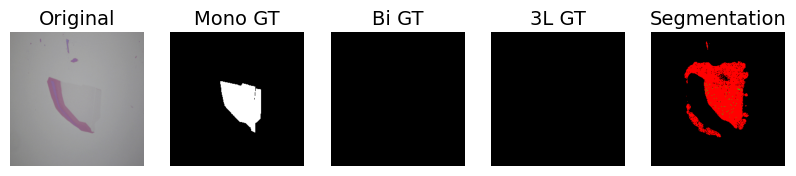

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


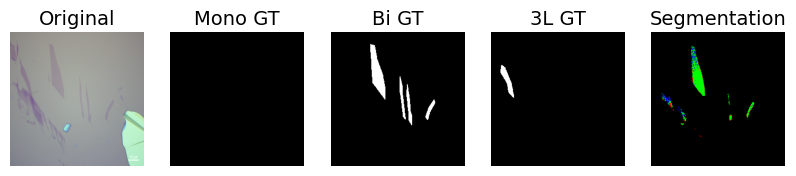

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


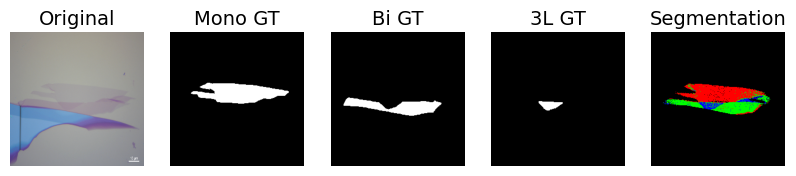

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


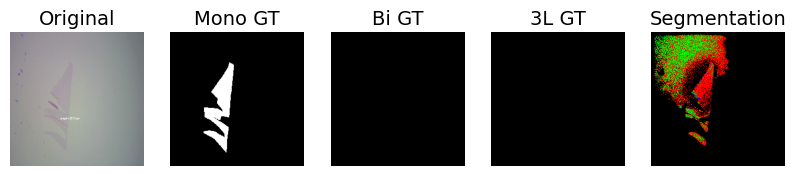

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


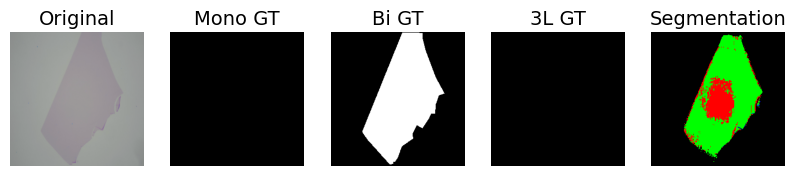

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


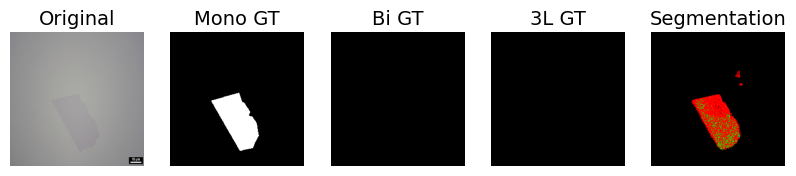

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


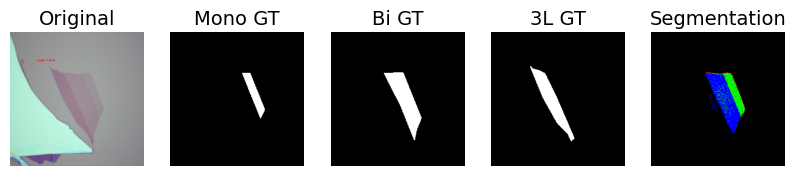

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


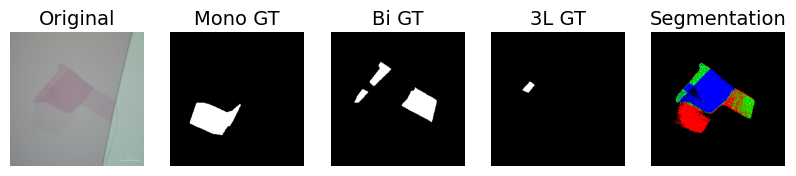

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


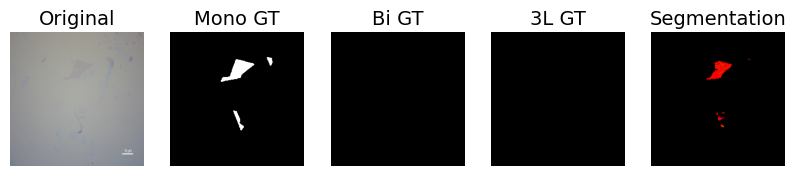

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


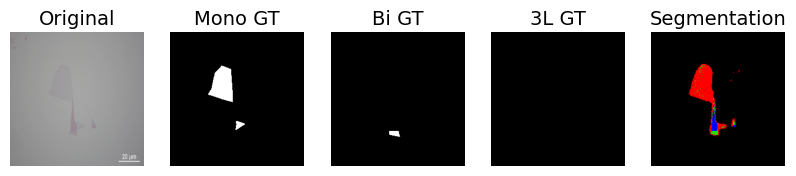

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


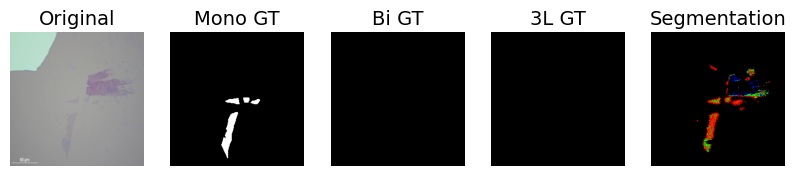

In [54]:
log_segmentation_pics(dataset_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


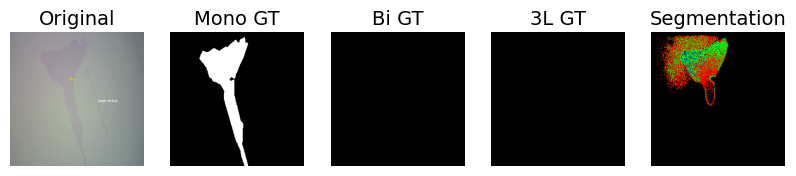

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


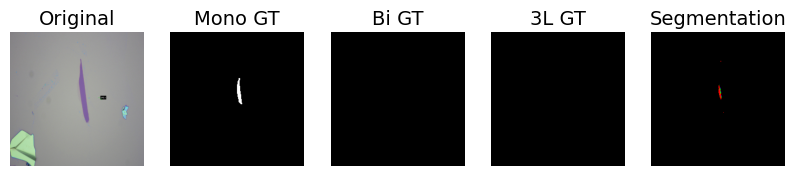

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


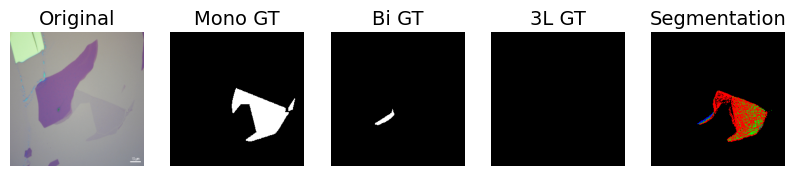

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


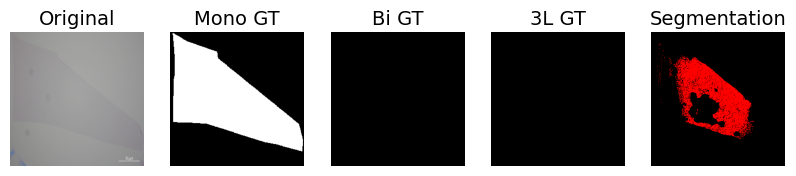

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


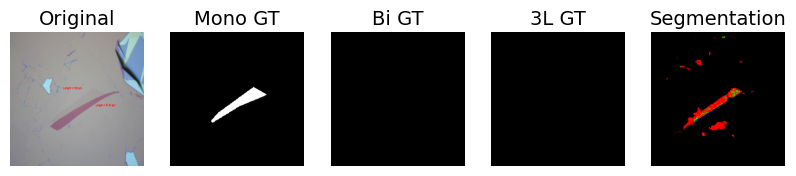

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


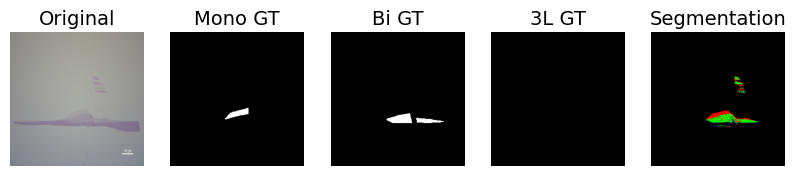

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


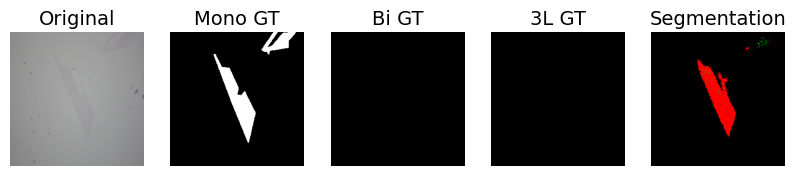

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


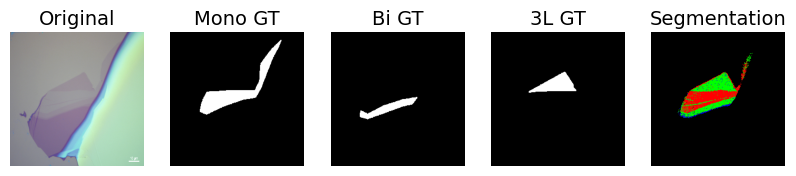

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


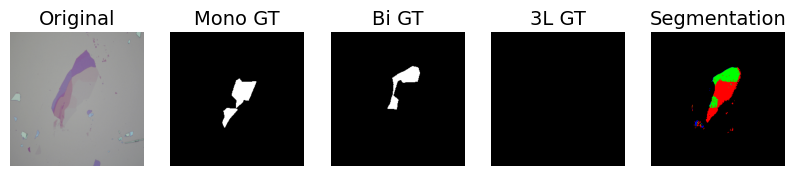

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


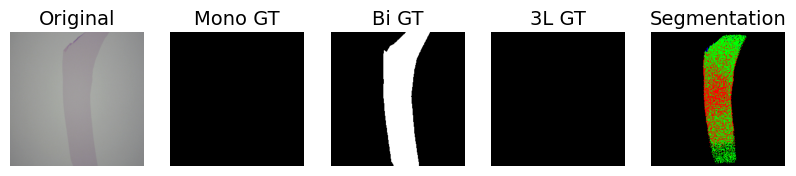

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


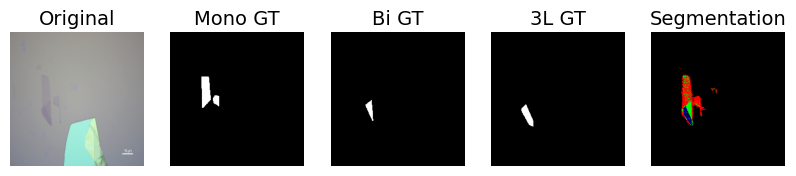

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


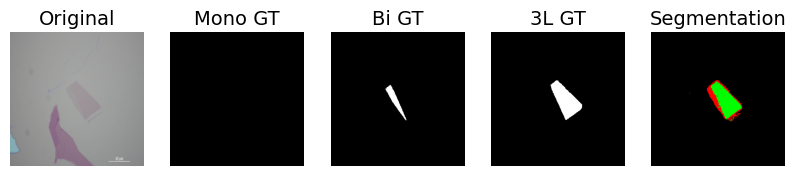

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


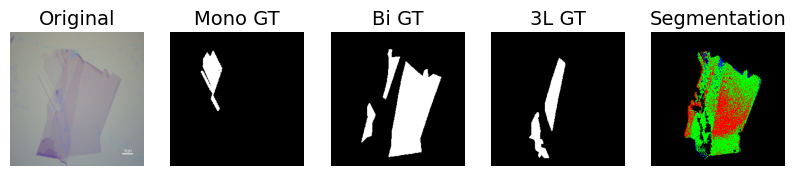

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


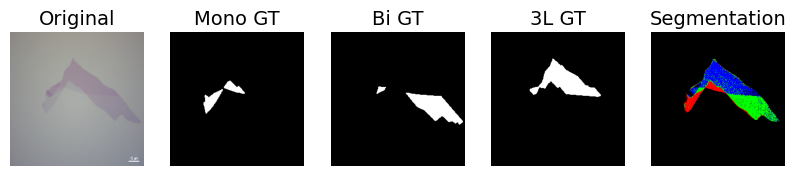

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


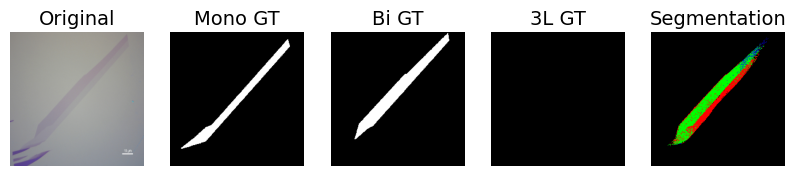

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


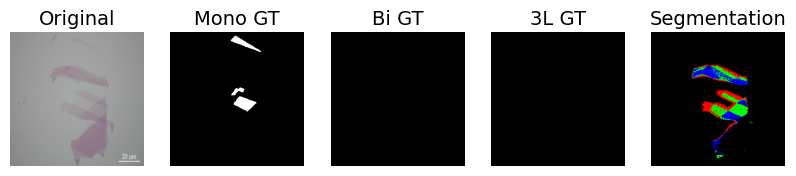

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


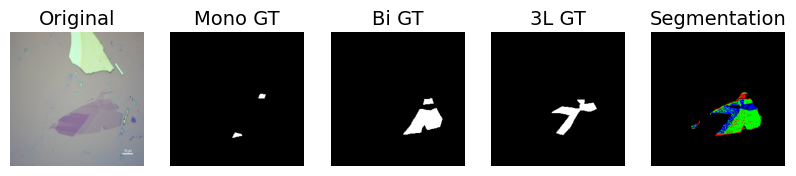

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


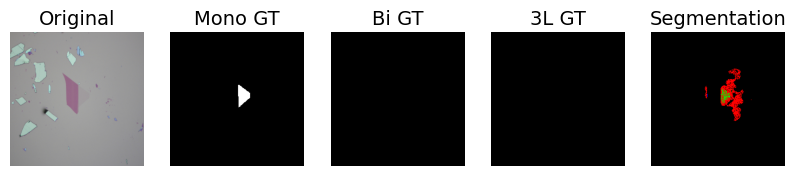

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


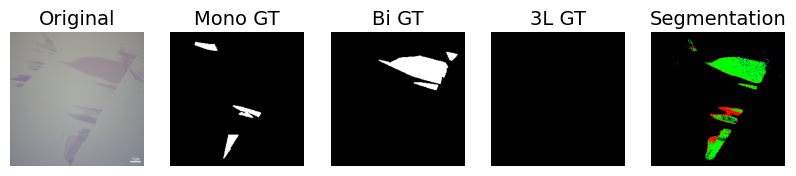

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


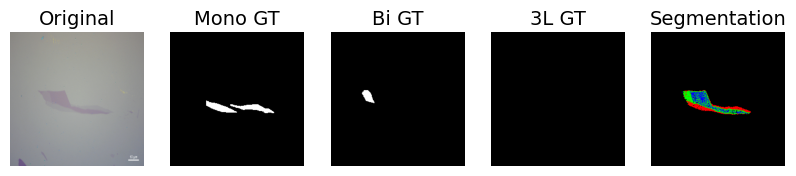

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


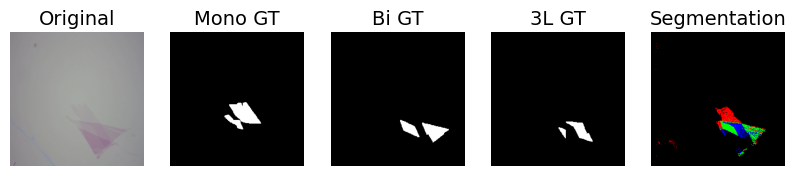

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


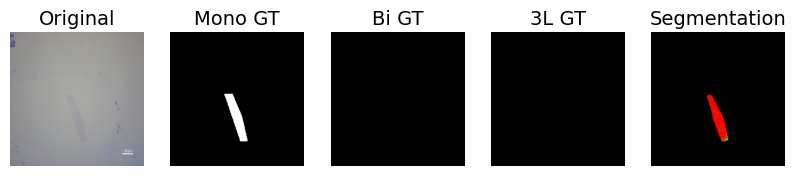

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


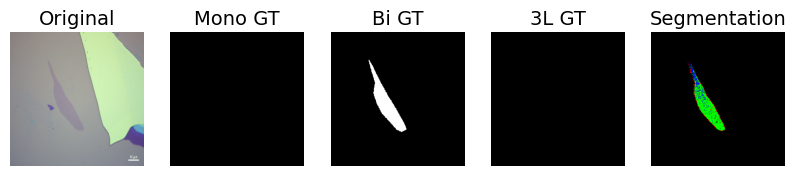

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


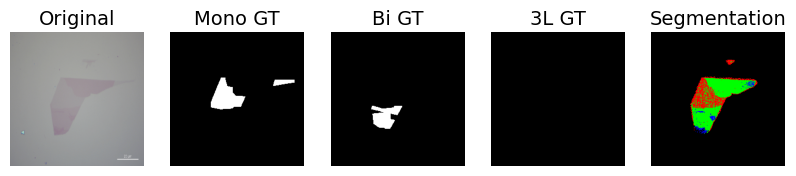

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


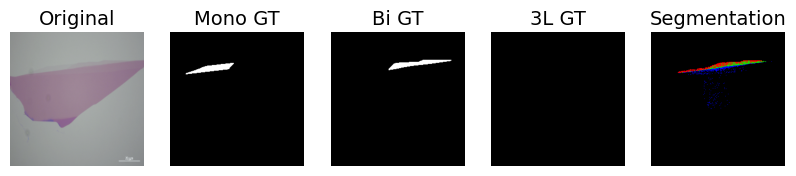

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


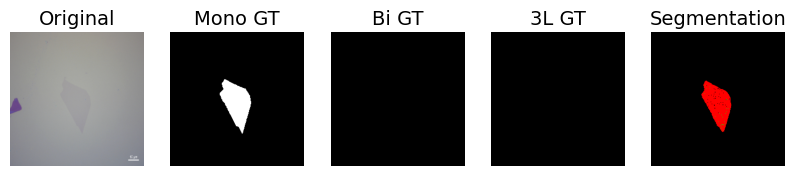

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


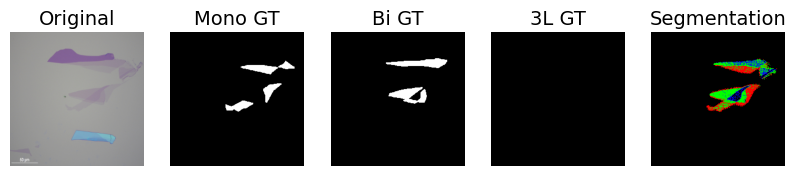

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


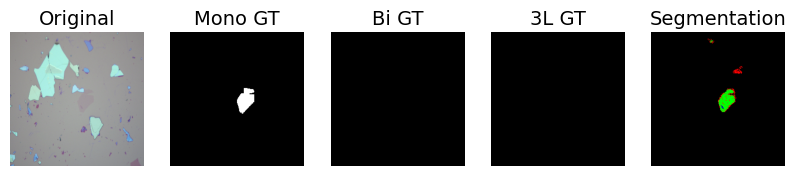

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


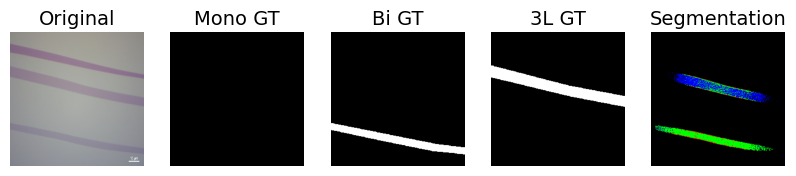

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


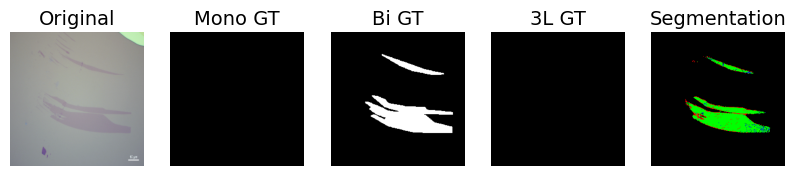

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


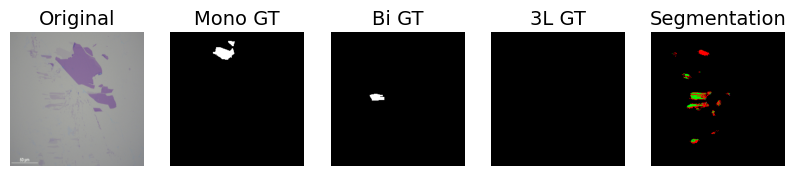

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


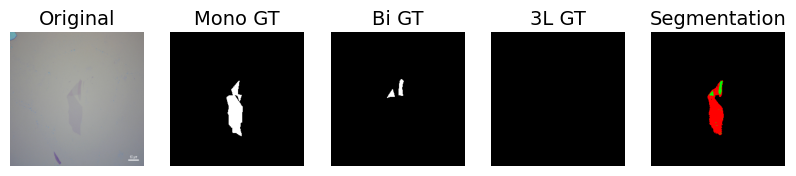

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


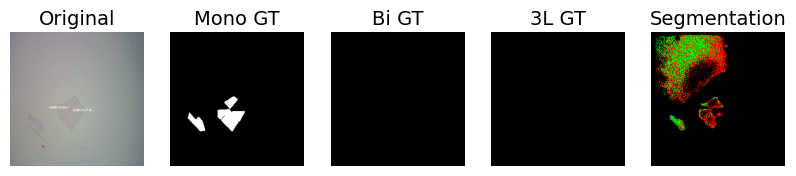

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


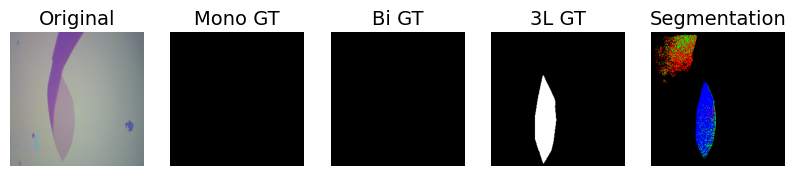

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


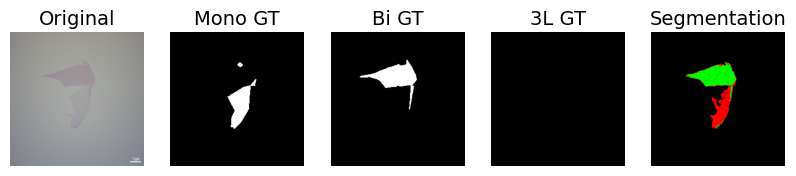

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


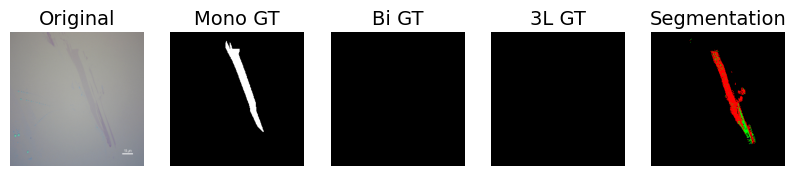

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


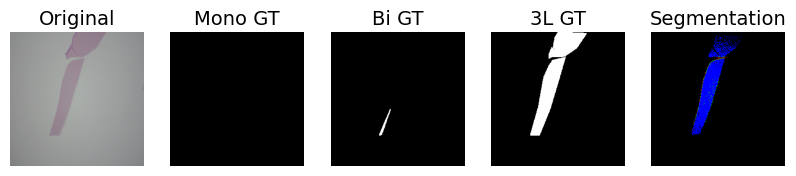

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


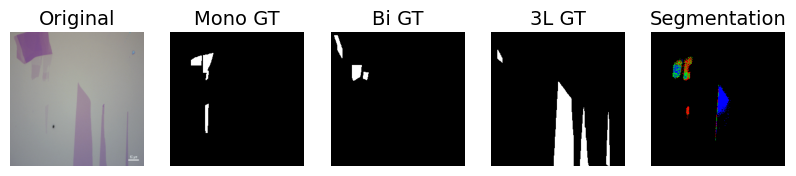

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


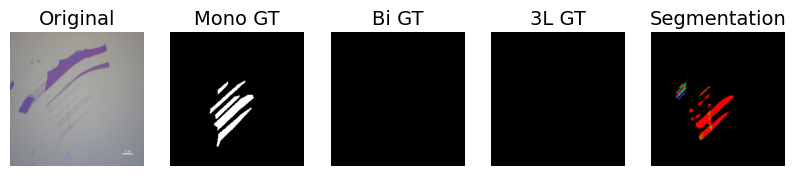

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


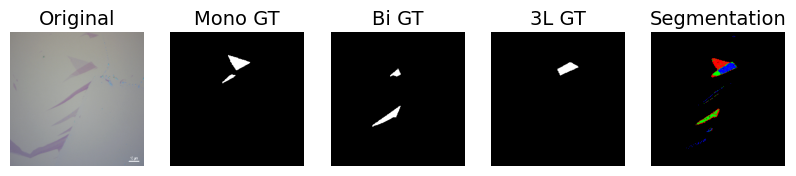

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


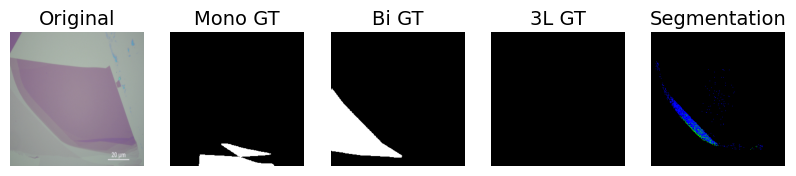

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


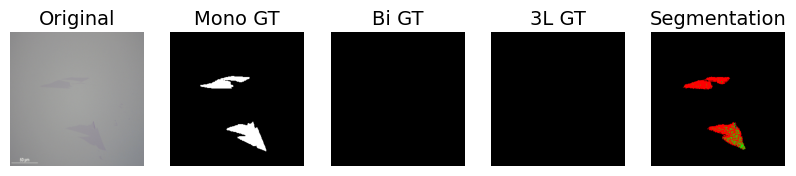

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


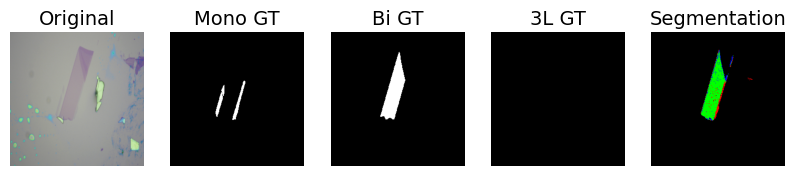

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


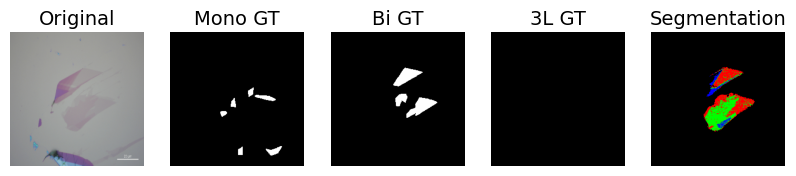

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


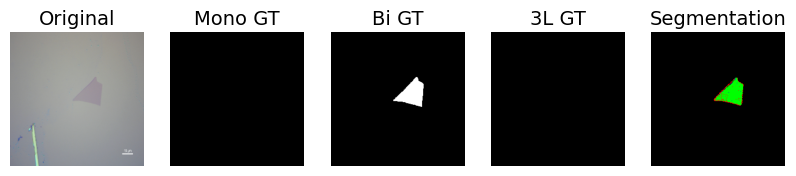

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


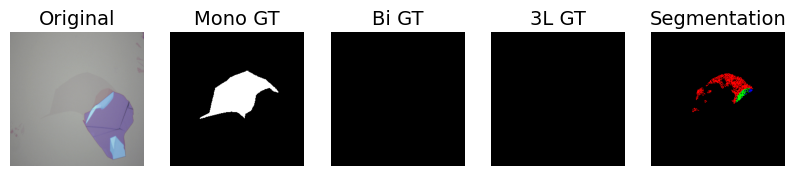

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


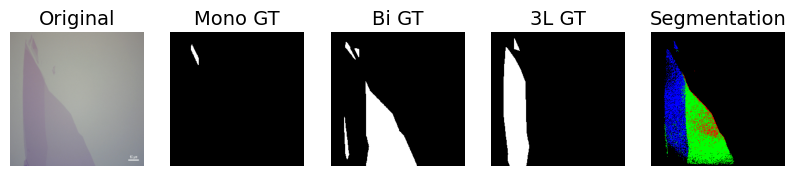

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


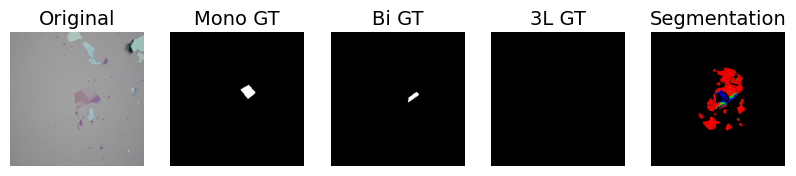

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


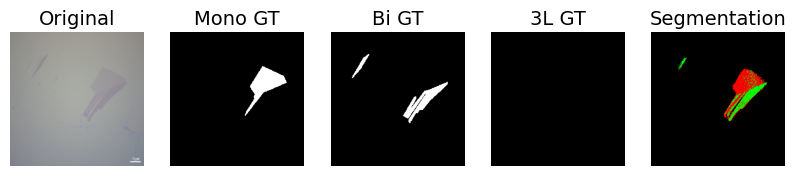

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


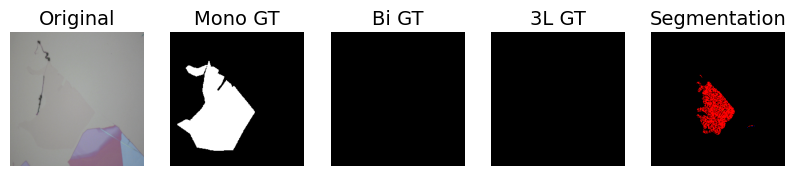

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


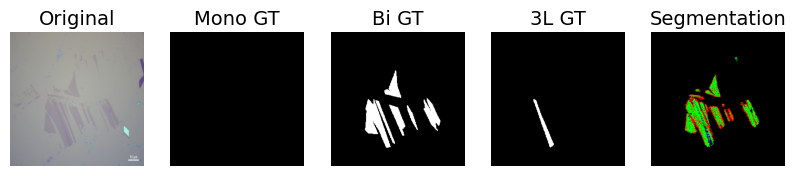

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


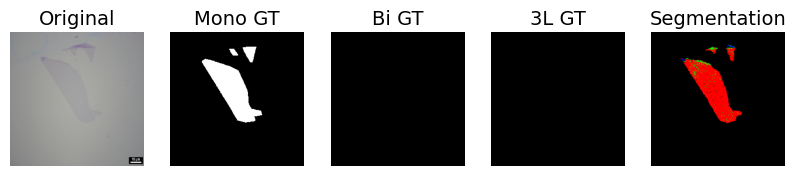

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


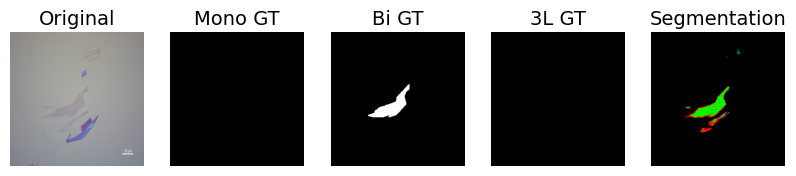

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


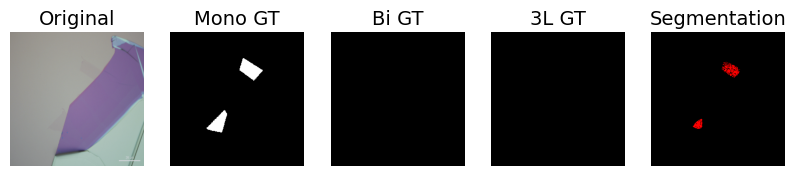

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


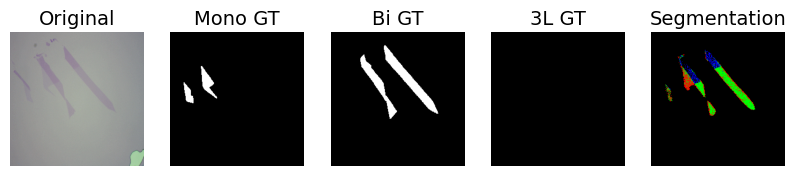

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


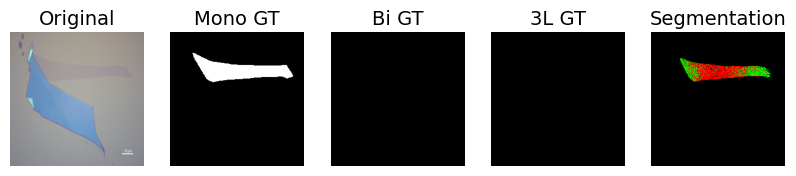

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


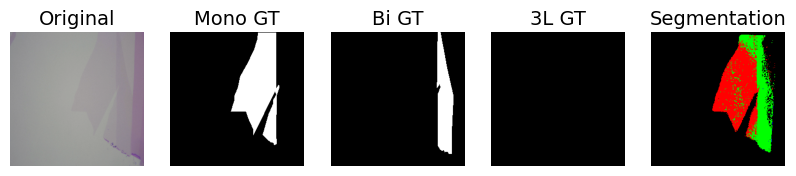

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


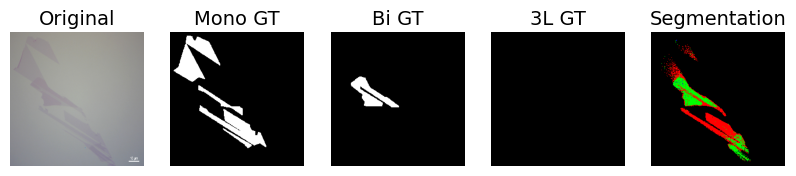

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


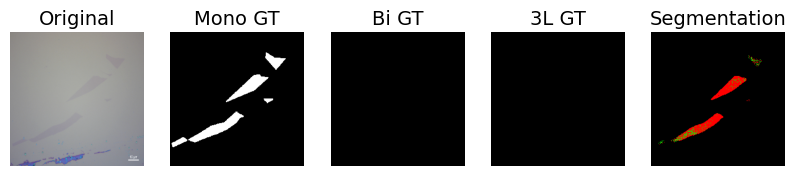

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


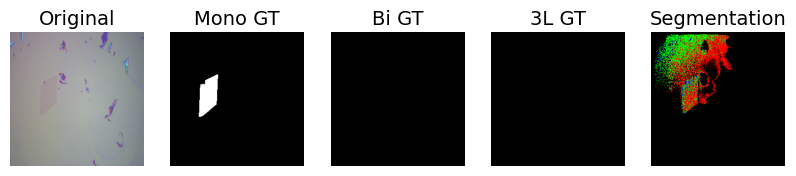

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


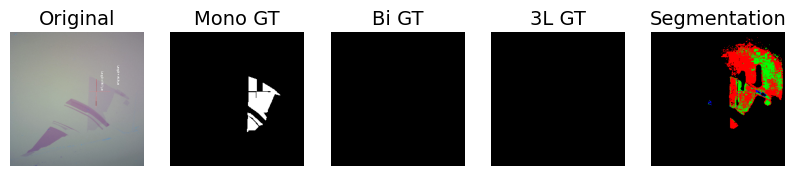

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


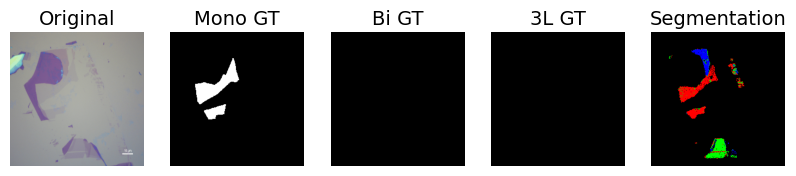

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


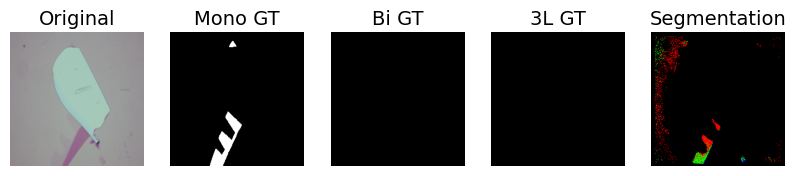

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


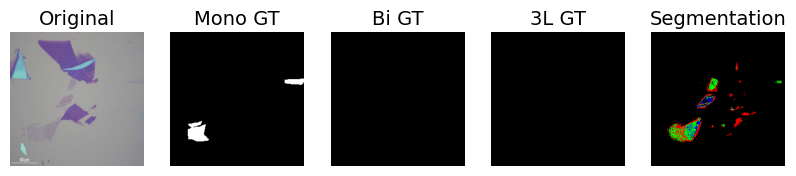

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


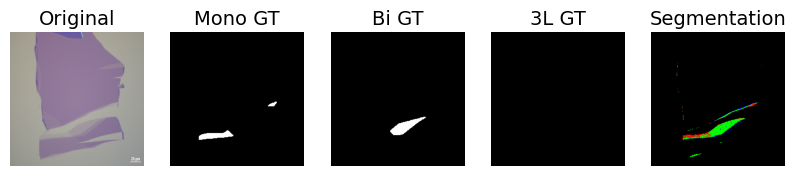

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


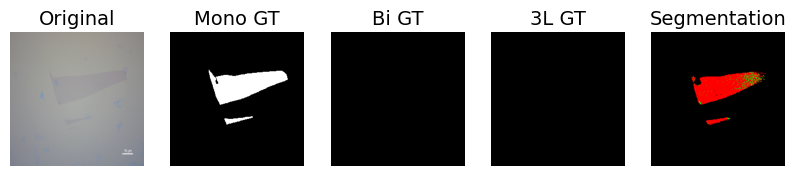

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


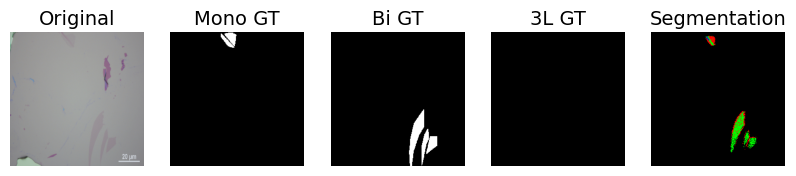

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


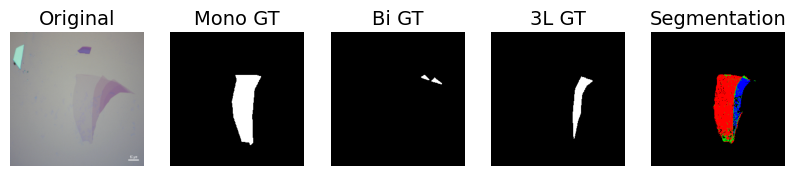

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


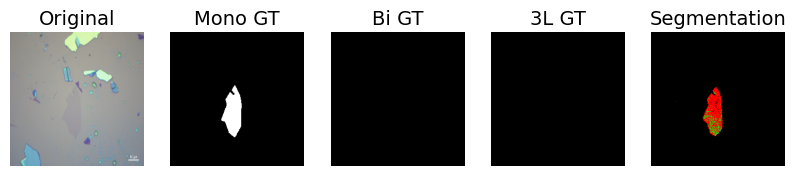

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


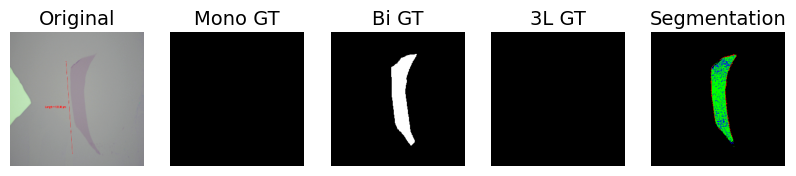

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


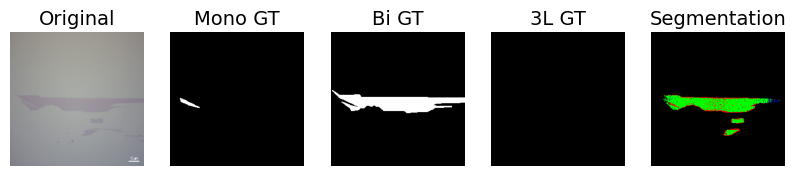

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


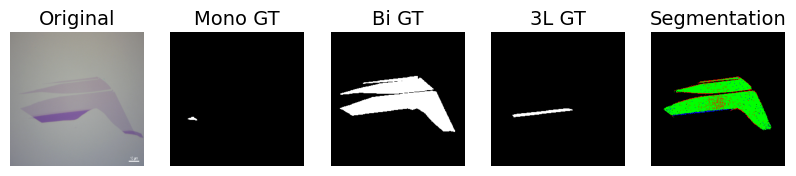

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


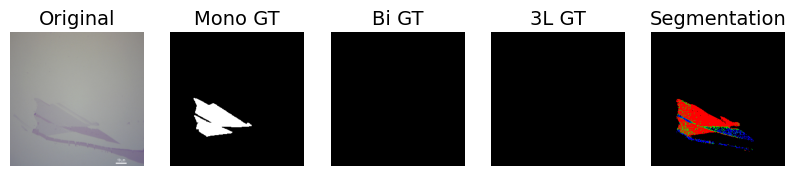

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


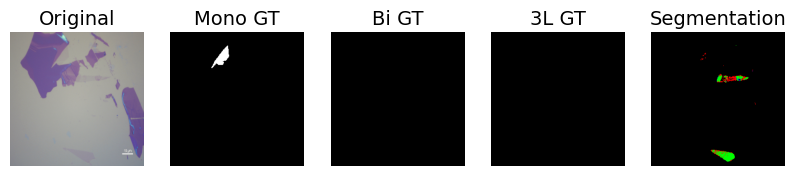

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


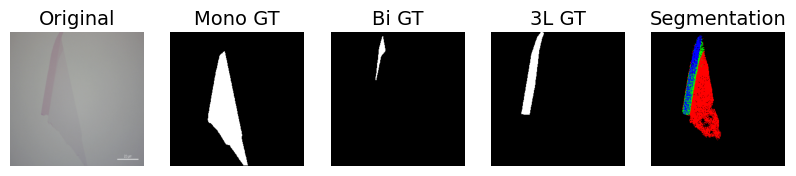

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


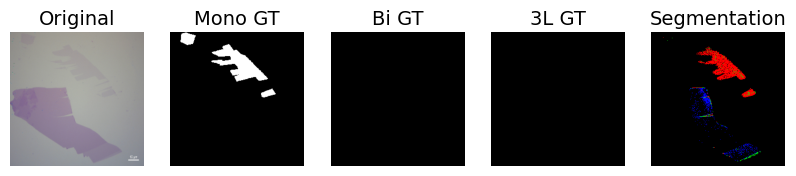

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


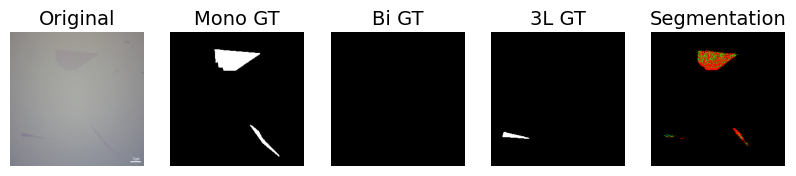

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


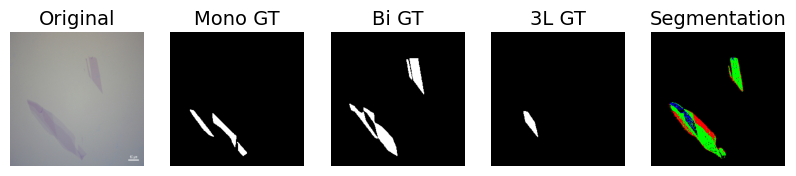

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


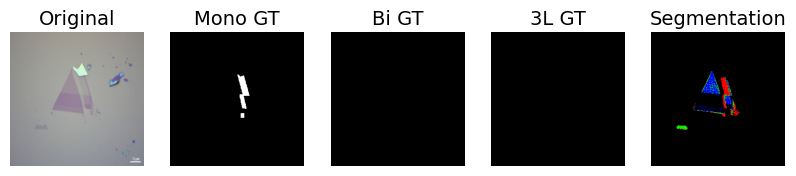

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


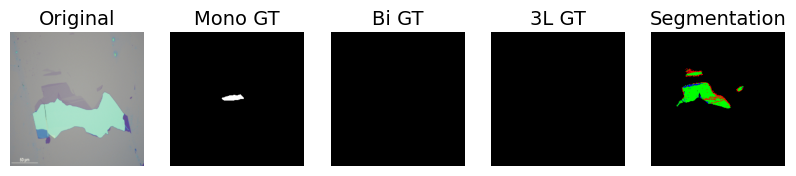

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


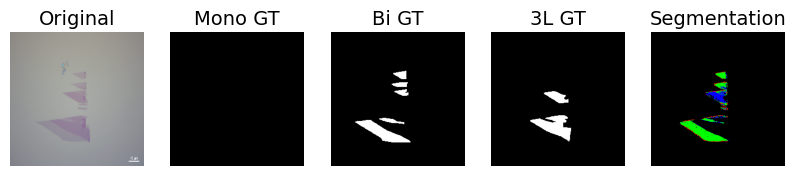

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


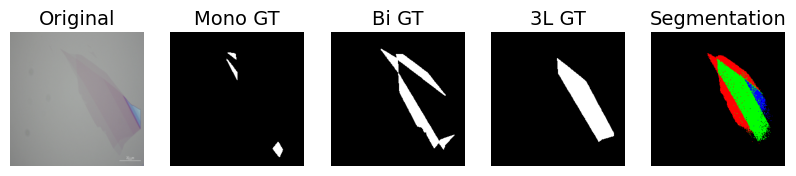

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


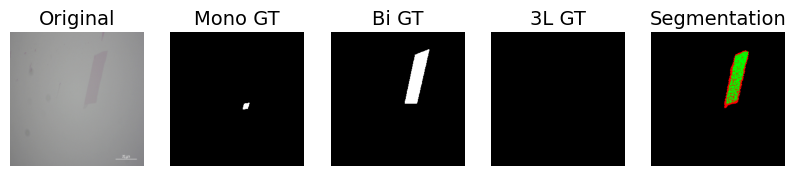

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


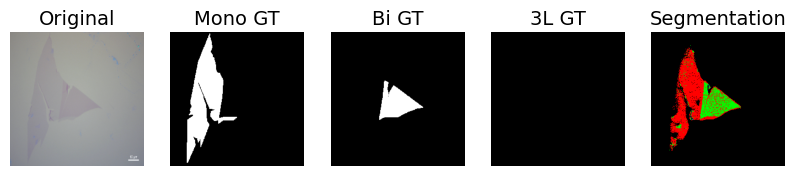

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


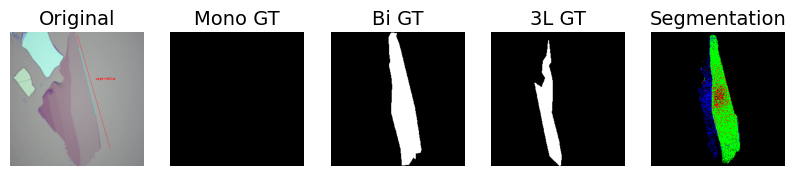

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


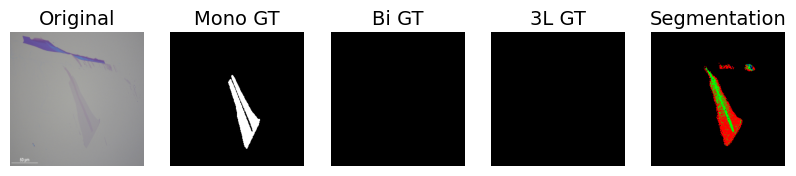

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


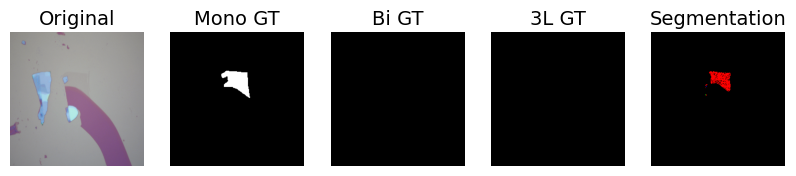

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


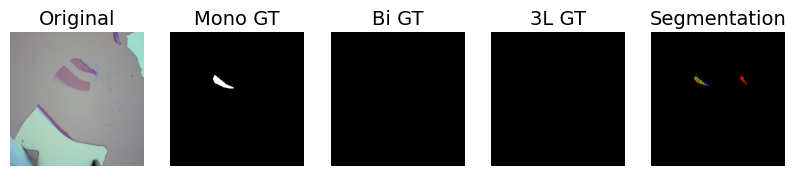

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


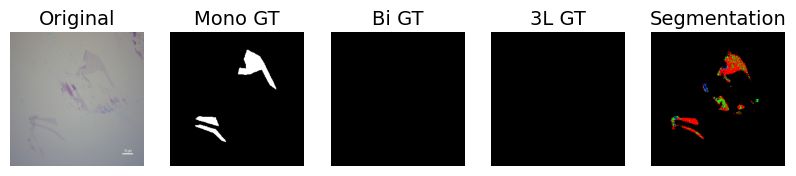

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


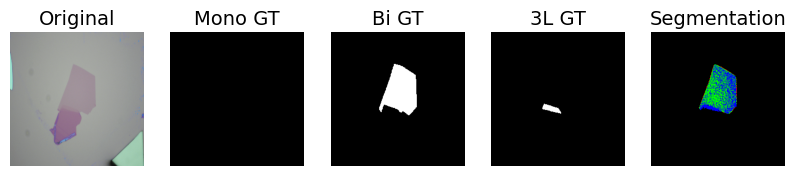

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


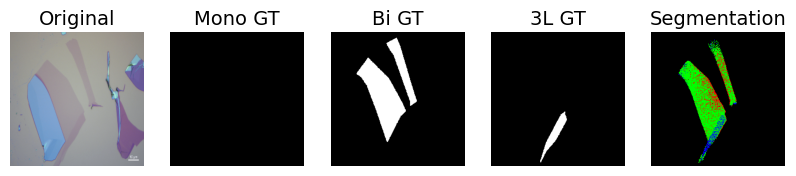

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


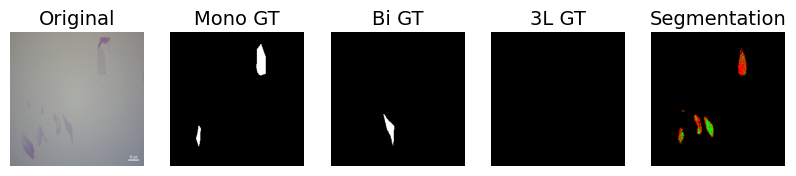

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


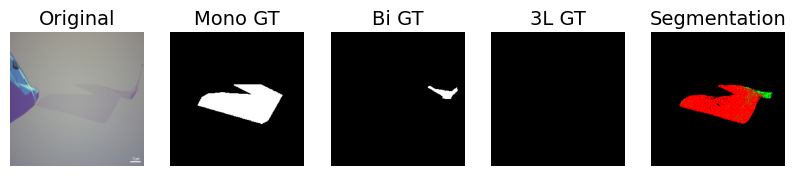

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


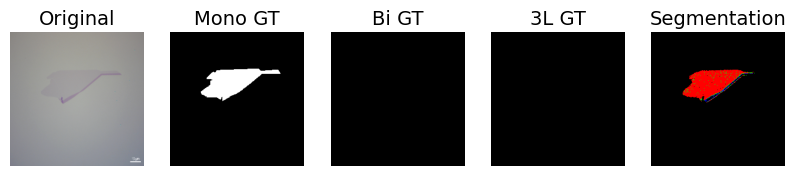

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


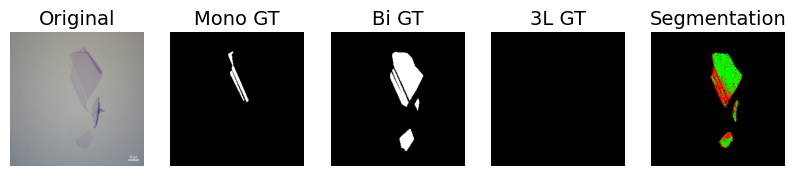

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


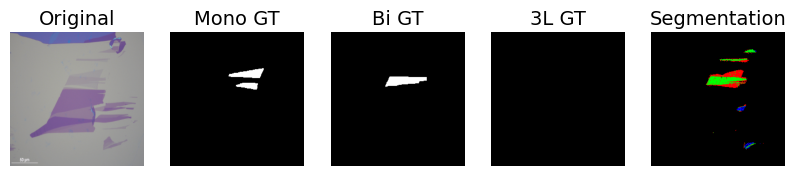

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


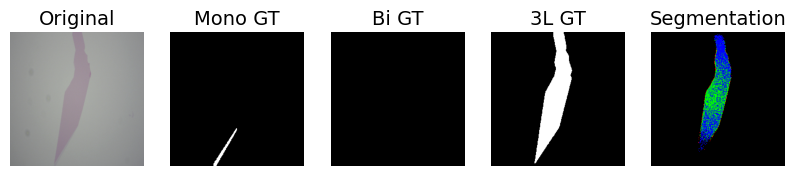

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


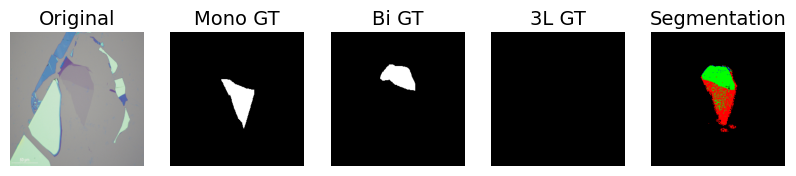

In [55]:
log_segmentation_pics(dataset_train)

In [49]:
def get_predictions(dataset):
    result = []
    for i in tqdm(dataset.image_ids):
        raw = cv2.resize(dataset.load_image(i), dsize=DEFAULT_INPUT_SIZE[:2], interpolation=cv2.INTER_CUBIC) / 255.
        segm = get_segmentation(raw)
        result.append(segm)
    return result

In [50]:
train_preds = get_predictions(dataset_train)
val_preds = get_predictions(dataset_val)

100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


The end.

In [50]:
for i in dataset_train.image_ids:
    print(dataset_train.load_image(i).shape)

(422, 592, 3)
(462, 649, 3)
(487, 685, 3)
(462, 650, 3)
(759, 569, 3)
(462, 650, 3)
(377, 503, 3)
(494, 695, 3)
(427, 599, 3)
(410, 576, 3)
(410, 576, 3)
(458, 644, 3)
(458, 644, 3)
(476, 670, 3)
(447, 629, 3)
(468, 658, 3)
(467, 657, 3)
(476, 670, 3)
(443, 623, 3)
(434, 612, 3)
(464, 652, 3)
(442, 622, 3)
(465, 654, 3)
(459, 646, 3)
(460, 647, 3)
(461, 648, 3)
(476, 670, 3)
(477, 671, 3)
(430, 606, 3)
(463, 652, 3)
(478, 672, 3)
(458, 644, 3)
(476, 669, 3)
(463, 650, 3)
(436, 614, 3)
(468, 657, 3)
(478, 672, 3)
(468, 658, 3)
(469, 659, 3)
(410, 577, 3)
(464, 653, 3)
(455, 639, 3)
(475, 669, 3)
(452, 636, 3)
(478, 672, 3)
(463, 651, 3)
(478, 672, 3)
(452, 636, 3)
(453, 638, 3)
(445, 626, 3)
(478, 672, 3)
(450, 633, 3)
(434, 611, 3)
(472, 664, 3)
(462, 649, 3)
(450, 634, 3)
(465, 654, 3)
(460, 647, 3)
(477, 670, 3)
(477, 671, 3)
(456, 640, 3)
(394, 526, 3)
(396, 527, 3)
(374, 499, 3)
(407, 571, 3)
(472, 664, 3)
(465, 654, 3)
(410, 576, 3)
(384, 512, 3)
(419, 589, 3)
(442, 622, 3)
(502, 

AttributeError: 'AxesSubplot' object has no attribute 'ravel'

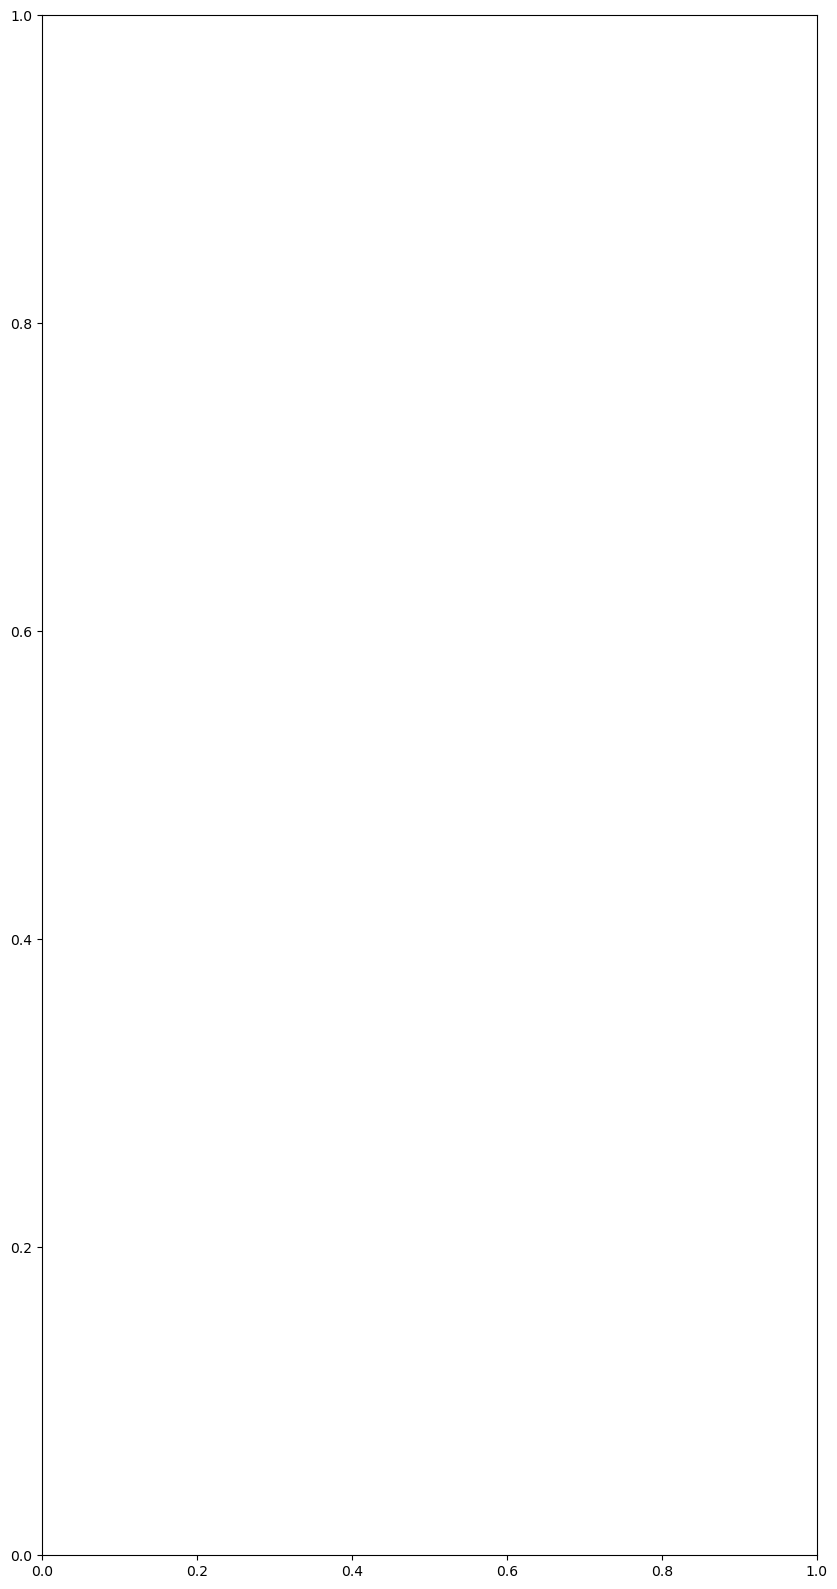

In [52]:
print_images([dataset_train.load_image(dataset_train.image_ids[-2])], ['large pricture'])